In [1]:
#imports
import numpy as np
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt

from non_layered_neural_net import nlnn



In [119]:
#Run_hyperparameters
training_run = 2
neuron_count=1000
connection_probability_dropoff=3
connection_probability_scalar=0.00003
input_layer_connectivity_multiplyer=50
output_layer_connectivity_multiplyer=20
weight_initialisation_range=2
distances_from_input_output_layer_to_main_neuron_field=0.1

n_closes_neurons_connection_probability="connection_prob"
distance_metric="euclidian"
activation_function="sigmoid"

generation_size=12
n_survivors=3
mutation_range="dynamic"
training_set_size=1000
mutation_range_reducing_interval="none"
mutation_range_reducing_factor="none"

reducing_mutaiton_range="no"
stochastic_mutation_range="yes"
multiple_training_sets="yes"
keep_best_of_n_generations_keep_n_best="keep_n_best"
allow_topological_modification="no"
non_uniform_distribution_in_stochastic_mutation_range="no"


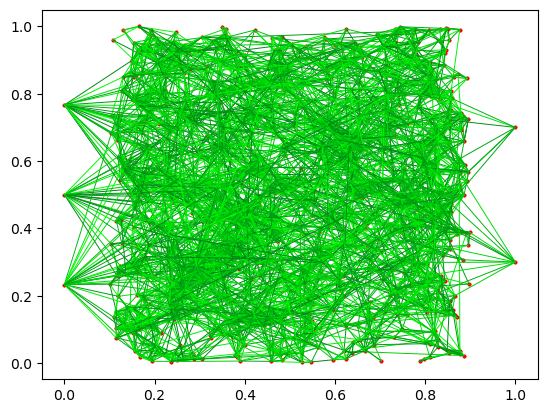

In [106]:
net = nlnn(hidden_neurons= 1000, input_neurons = 3, output_neurons = 2)
net.initialise_structure(connection_probability_dropoff=3, connection_probabily_scalar=0.00003)
#net.initialise_randomly()
net.display_net()

In [13]:
#load dataset
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [14]:
#setting up conventional model 
from keras import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(3, input_shape=(28*28,), activation='sigmoid'))
#model.add(Dense(8, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])


In [15]:
#model.fit(mod_x_train, one_hot_y_train, epochs=10, batch_size=32)

In [16]:
#evaluate model
#accuracy = model.evaluate(mod_x_test, one_hot_y_test)
#print(accuracy)

In [18]:
#try on all classes
#one hot encode
def one_hot_encode(x):
    out = np.zeros((len(x), max(x)+1))
    for i in range(len(x)):
        out[i][x[i]] = 1
    return out

y_train_ohe = one_hot_encode(train_y)
y_test_ohe = one_hot_encode(test_y)
#flatten images
x_train = train_X.reshape(len(train_X), 28*28)
x_test = test_X.reshape(len(test_X), 28*28)

x_test = np.array_split(x_test, 10)
y_test_ohe = np.array_split(y_test_ohe, 10)


model_all = Sequential()
#model_all.add(Dense(3, input_shape=(28*28,), activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))
model_all.add(Dense(10, activation='softmax'))

# compile the keras model
model_all.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

model_all.fit(x_train, y_train_ohe, epochs=10, batch_size=32)

(1000, 784)
(1000, 10)
Epoch 1/10
   1/1875 [..............................] - ETA: 5:24 - loss: 63.3809 - accuracy: 0.0938

2023-03-04 18:07:08.389739: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-04 18:07:08.492436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 7s 3ms/step - loss: 5.8490 - accuracy: 0.8264
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.7819 - accuracy: 0.8504
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.6803 - accuracy: 0.8560
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.6811 - accuracy: 0.8560
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5785 - accuracy: 0.8579
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 4.6293 - accuracy: 0.8589
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5173 - accuracy: 0.8609
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5344 - accuracy: 0.8602
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5437 - accuracy: 0.8604
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 4.5442 - accurac

In [60]:
#evaluate model
print(x_test[2].shape)
print(y_test_ohe[2].shape)

print(x_train.shape)
print(y_train_ohe.shape)
accuracy = model.evaluate(x_test, y_test_ohe)
print(accuracy)

(1000, 784)
(1000, 10)
(60000, 784)
(60000, 10)


ValueError: in user code:

    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/engine/training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/hannes/miniforge3/lib/python3.10/site-packages/keras/backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 3) vs (None, 10)).


In [19]:
#setting up evolutionary pipeline
performance_over_time = []
#creating initial population
population_size = 12
def create_population(population_size):
    population = []
    print("Creating networks")
    for i in range(population_size):
        net = nlnn(output_neurons = 10, hidden_neurons = 1000)
        net.initialise_structure(connection_probability_dropoff=3, connection_probabily_scalar=0.00003)
        #net.initialise_randomly()
        population.append(net)
        print("|", end="")

    print("done!")
    return population


networks = create_population(population_size)

Creating networks
||||||||||||done!


In [22]:
def get_perf(t):
        return t[0]

#measure performance of all the networks
def evaluate_performance(population, x, y):
    performances = []
    print("evaluating performances", end="")
    for net in population:
        predictions = net.predict(x, 8)[0]
        correct_count = len(x)-(np.sum(np.abs(y - predictions))/2)
        performances.append((correct_count/len(x), net))
        #print(correct_count/len(x))
        print("|", end="")
    print(" done!", end=" ")
    #sort by best performance
    performances.sort(key = get_perf, reverse = True)
    return performances

evaluated_networks = evaluate_performance(networks, x_test[1], y_test_ohe[1])
print("best performer of this generation :", evaluated_networks[0][0])
performance_over_time.append(np.array(evaluated_networks)[:,0])

evaluating performances|||||||||||| done! best performer of this generation : 0.13


In [23]:
import multiprocess as mp

def evaluate_net(net):
    predictions = net.predict(x_test, 10)[0]
    correct_count = len(x_test)-(np.sum(np.abs(y_test_ohe - predictions))/2)
    return (correct_count/len(x_test), net)

def evaluate_performance_parallel(population):
    print("evaluating performances", end="")
    with mp.Pool() as pool:
        performances = pool.map(evaluate_net, population)
    print(" done!", end=" ")
    performances.sort(key = get_perf, reverse = True)
    return performances



In [24]:
#the n best performing networks will be selected
n = 3
mutation_range = 0.1

def repopulate(evaluated_networks, mutation_range, n):
    offspring_per_network = int(population_size/n)
    next_gen = [i[1] for i in evaluated_networks[:n]]
    for net in next_gen:
        next_gen = next_gen+net.reproduce(offspring_per_network, mutation_range)
    return next_gen
    
next_generation = repopulate(evaluated_networks, mutation_range,n)

In [32]:
performance_over_time = []

In [49]:
test_sets_used = []
mutation_ranges = []

In [33]:
print(np.array(performance_over_time))
for i in performance_over_time:
    print(len(i))

[]


generation 11120  test set: 0 evaluating performances|||||||||||| done!  best: 0.397 second: 0.396 third: 0.396
mutating in range: 0.0039519041367356515


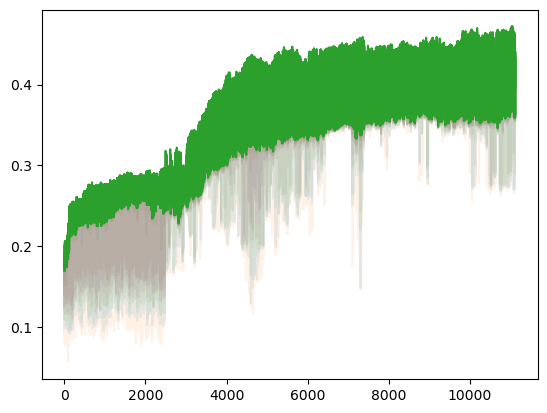

average best of last 100 generations 0.40707
generation 11121  test set: 2 evaluating performances|||||||||||| done!  best: 0.367 second: 0.367 third: 0.367
mutating in range: 0.048602317843861154
generation 11122  test set: 0 evaluating performances|||||||||||| done!  best: 0.4 second: 0.397 third: 0.396
mutating in range: 0.008390447580504102
generation 11123  test set: 9 evaluating performances|||||||||||| done!  best: 0.437 second: 0.436 third: 0.436
mutating in range: 0.04934051115074678
generation 11124  test set: 7 evaluating performances|||||||||||| done!  best: 0.433 second: 0.432 third: 0.43
mutating in range: 0.04929707667755337
generation 11125  test set: 4 evaluating performances|||||||||||| done!  best: 0.363 second: 0.361 third: 0.361
mutating in range: 0.02751764479624475
generation 11126  test set: 7 evaluating performances|||||||||||| done!  best: 0.432 second: 0.431 third: 0.43
mutating in range: 0.009937354048318043
generation 11127  test set: 3 evaluating performan

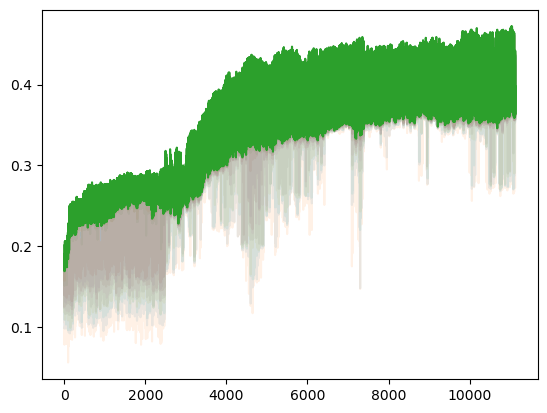

average best of last 100 generations 0.40620000000000006
generation 11131  test set: 9 evaluating performances|||||||||||| done!  best: 0.438 second: 0.436 third: 0.435
mutating in range: 0.009647011181954941
generation 11132  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.384 third: 0.384
mutating in range: 0.033068447285222895
generation 11133  test set: 4 evaluating performances|||||||||||| done!  best: 0.363 second: 0.363 third: 0.363
mutating in range: 0.006108344635977242
generation 11134  test set: 9 evaluating performances|||||||||||| done!  best: 0.436 second: 0.436 third: 0.436
mutating in range: 0.03195763662790345
generation 11135  test set: 8 evaluating performances|||||||||||| done!  best: 0.465 second: 0.464 third: 0.464
mutating in range: 0.01237638192681751
generation 11136  test set: 6 evaluating performances|||||||||||| done!  best: 0.443 second: 0.442 third: 0.441
mutating in range: 0.003453001448112447
generation 11137  test set: 2 eva

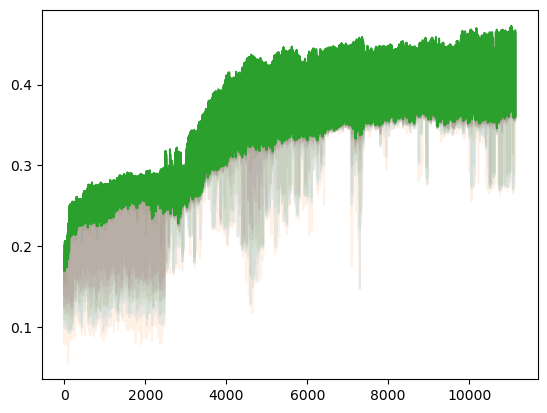

average best of last 100 generations 0.4041400000000001
generation 11141  test set: 4 evaluating performances|||||||||||| done!  best: 0.362 second: 0.362 third: 0.361
mutating in range: 0.012752700296498927
generation 11142  test set: 1 evaluating performances|||||||||||| done!  best: 0.362 second: 0.36 third: 0.36
mutating in range: 0.037208339876238665
generation 11143  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.439 third: 0.437
mutating in range: 0.015095651101139286
generation 11144  test set: 8 evaluating performances|||||||||||| done!  best: 0.465 second: 0.465 third: 0.464
mutating in range: 0.0027333316333229165
generation 11145  test set: 4 evaluating performances|||||||||||| done!  best: 0.362 second: 0.362 third: 0.362
mutating in range: 0.02067456674587158
generation 11146  test set: 4 evaluating performances|||||||||||| done!  best: 0.362 second: 0.362 third: 0.362
mutating in range: 0.04076129619882716
generation 11147  test set: 5 evalu

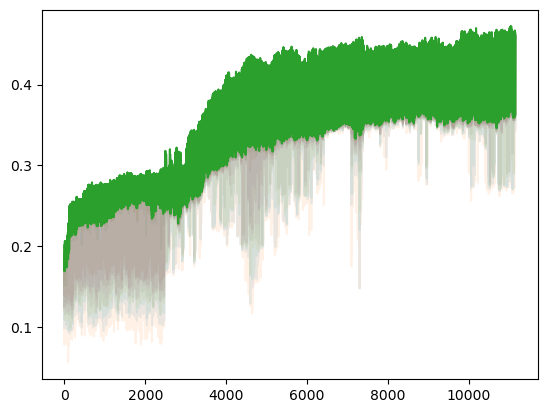

average best of last 100 generations 0.4032299999999999
generation 11151  test set: 8 evaluating performances|||||||||||| done!  best: 0.461 second: 0.461 third: 0.461
mutating in range: 0.01855400283739483
generation 11152  test set: 3 evaluating performances|||||||||||| done!  best: 0.382 second: 0.381 third: 0.381
mutating in range: 0.009533852395966498
generation 11153  test set: 6 evaluating performances|||||||||||| done!  best: 0.446 second: 0.445 third: 0.445
mutating in range: 0.044407291387109714
generation 11154  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.382 third: 0.382
mutating in range: 0.048271020905002134
generation 11155  test set: 9 evaluating performances|||||||||||| done!  best: 0.438 second: 0.437 third: 0.437
mutating in range: 0.015773372233051697
generation 11156  test set: 1 evaluating performances|||||||||||| done!  best: 0.356 second: 0.355 third: 0.355
mutating in range: 0.037043740918539673
generation 11157  test set: 9 eva

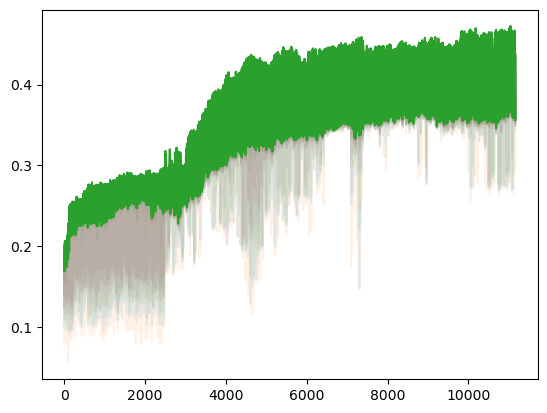

average best of last 100 generations 0.40351
generation 11161  test set: 2 evaluating performances|||||||||||| done!  best: 0.358 second: 0.358 third: 0.357
mutating in range: 0.04813138373316014
generation 11162  test set: 5 evaluating performances|||||||||||| done!  best: 0.441 second: 0.439 third: 0.438
mutating in range: 0.0275506106107443
generation 11163  test set: 2 evaluating performances|||||||||||| done!  best: 0.362 second: 0.361 third: 0.36
mutating in range: 0.016402014464855046
generation 11164  test set: 5 evaluating performances|||||||||||| done!  best: 0.444 second: 0.443 third: 0.442
mutating in range: 0.02391997632504063
generation 11165  test set: 5 evaluating performances|||||||||||| done!  best: 0.444 second: 0.444 third: 0.443
mutating in range: 0.023288641292745084
generation 11166  test set: 8 evaluating performances|||||||||||| done!  best: 0.461 second: 0.461 third: 0.46
mutating in range: 0.02654803691287746
generation 11167  test set: 9 evaluating performan

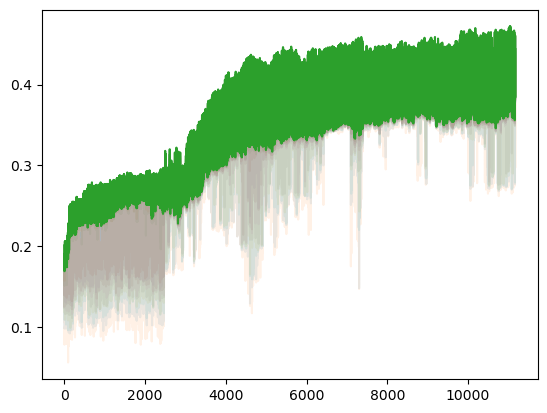

average best of last 100 generations 0.40486000000000005
generation 11171  test set: 9 evaluating performances|||||||||||| done!  best: 0.44 second: 0.439 third: 0.438
mutating in range: 0.038966460192505915
generation 11172  test set: 7 evaluating performances|||||||||||| done!  best: 0.429 second: 0.429 third: 0.428
mutating in range: 0.019314415054155012
generation 11173  test set: 4 evaluating performances|||||||||||| done!  best: 0.363 second: 0.362 third: 0.361
mutating in range: 0.04628450381553276
generation 11174  test set: 1 evaluating performances|||||||||||| done!  best: 0.361 second: 0.358 third: 0.358
mutating in range: 0.0041493483610369865
generation 11175  test set: 2 evaluating performances|||||||||||| done!  best: 0.359 second: 0.359 third: 0.359
mutating in range: 0.02516542492679379
generation 11176  test set: 2 evaluating performances|||||||||||| done!  best: 0.363 second: 0.362 third: 0.361
mutating in range: 0.03281694996458353
generation 11177  test set: 5 eval

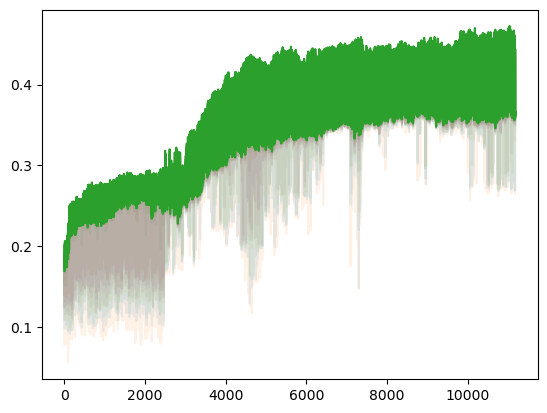

average best of last 100 generations 0.40182
generation 11181  test set: 6 evaluating performances|||||||||||| done!  best: 0.441 second: 0.44 third: 0.439
mutating in range: 0.042690202058055265
generation 11182  test set: 2 evaluating performances|||||||||||| done!  best: 0.366 second: 0.364 third: 0.363
mutating in range: 0.008879825221642573
generation 11183  test set: 4 evaluating performances|||||||||||| done!  best: 0.371 second: 0.37 third: 0.369
mutating in range: 0.027928901064498537
generation 11184  test set: 4 evaluating performances|||||||||||| done!  best: 0.371 second: 0.37 third: 0.37
mutating in range: 0.03042710984708541
generation 11185  test set: 5 evaluating performances|||||||||||| done!  best: 0.444 second: 0.443 third: 0.442
mutating in range: 0.026055068300500934
generation 11186  test set: 7 evaluating performances|||||||||||| done!  best: 0.426 second: 0.425 third: 0.425
mutating in range: 0.024426089822981247
generation 11187  test set: 7 evaluating perform

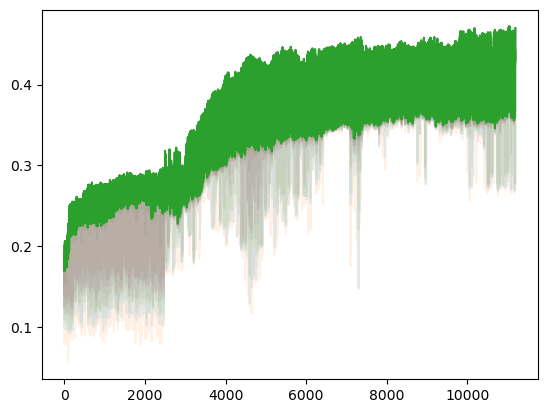

average best of last 100 generations 0.40318
generation 11191  test set: 4 evaluating performances|||||||||||| done!  best: 0.371 second: 0.371 third: 0.371
mutating in range: 0.03118815606520453
generation 11192  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.383 third: 0.382
mutating in range: 0.02594412189557669
generation 11193  test set: 6 evaluating performances|||||||||||| done!  best: 0.448 second: 0.446 third: 0.445
mutating in range: 0.01590936585678949
generation 11194  test set: 2 evaluating performances|||||||||||| done!  best: 0.368 second: 0.368 third: 0.368
mutating in range: 0.046363391811895895
generation 11195  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.384 third: 0.384
mutating in range: 0.041204278777014366
generation 11196  test set: 5 evaluating performances|||||||||||| done!  best: 0.446 second: 0.445 third: 0.445
mutating in range: 0.032343629715959395
generation 11197  test set: 0 evaluating perfo

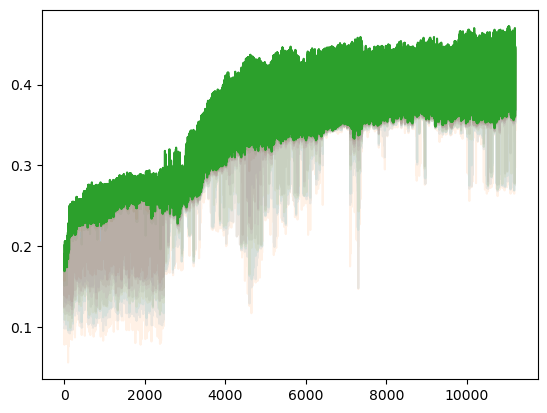

average best of last 100 generations 0.40462000000000004
generation 11201  test set: 5 evaluating performances|||||||||||| done!  best: 0.446 second: 0.446 third: 0.445
mutating in range: 0.003434791557212419
generation 11202  test set: 2 evaluating performances|||||||||||| done!  best: 0.368 second: 0.368 third: 0.367
mutating in range: 0.02367040358804491
generation 11203  test set: 5 evaluating performances|||||||||||| done!  best: 0.447 second: 0.446 third: 0.446
mutating in range: 0.03812747114775905
generation 11204  test set: 7 evaluating performances|||||||||||| done!  best: 0.43 second: 0.43 third: 0.429
mutating in range: 0.025927133888729914
generation 11205  test set: 7 evaluating performances|||||||||||| done!  best: 0.432 second: 0.431 third: 0.43
mutating in range: 0.023352526964558525
generation 11206  test set: 0 evaluating performances|||||||||||| done!  best: 0.399 second: 0.398 third: 0.398
mutating in range: 0.013614616764001015
generation 11207  test set: 8 evalua

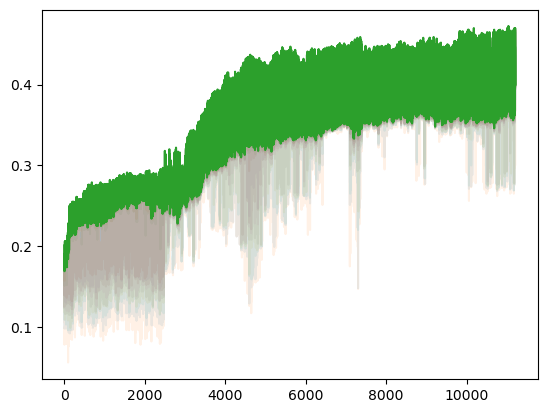

average best of last 100 generations 0.40838
generation 11211  test set: 4 evaluating performances|||||||||||| done!  best: 0.372 second: 0.37 third: 0.37
mutating in range: 0.023883378983205306
generation 11212  test set: 4 evaluating performances|||||||||||| done!  best: 0.372 second: 0.371 third: 0.371
mutating in range: 0.007151662621649568
generation 11213  test set: 5 evaluating performances|||||||||||| done!  best: 0.443 second: 0.443 third: 0.443
mutating in range: 0.0435025895316713
generation 11214  test set: 2 evaluating performances|||||||||||| done!  best: 0.37 second: 0.368 third: 0.367
mutating in range: 0.014150859607239713
generation 11215  test set: 6 evaluating performances|||||||||||| done!  best: 0.445 second: 0.443 third: 0.443
mutating in range: 0.048877648809070806
generation 11216  test set: 4 evaluating performances|||||||||||| done!  best: 0.372 second: 0.372 third: 0.372
mutating in range: 0.026142463057852724
generation 11217  test set: 0 evaluating perform

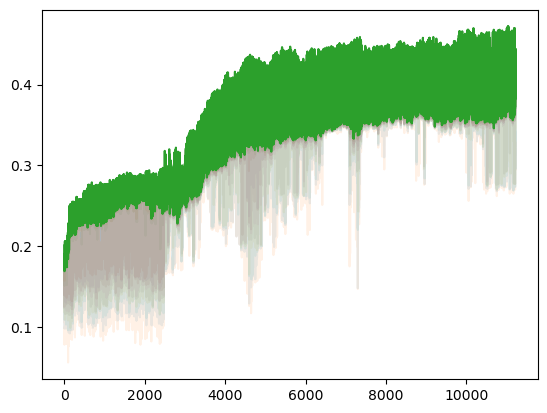

average best of last 100 generations 0.40959
generation 11221  test set: 1 evaluating performances|||||||||||| done!  best: 0.361 second: 0.36 third: 0.359
mutating in range: 0.045864665995847986
generation 11222  test set: 6 evaluating performances|||||||||||| done!  best: 0.445 second: 0.443 third: 0.443
mutating in range: 0.03765346124888661
generation 11223  test set: 6 evaluating performances|||||||||||| done!  best: 0.445 second: 0.445 third: 0.443
mutating in range: 0.031545888357875654
generation 11224  test set: 6 evaluating performances|||||||||||| done!  best: 0.445 second: 0.445 third: 0.445
mutating in range: 0.023963113613013926
generation 11225  test set: 7 evaluating performances|||||||||||| done!  best: 0.435 second: 0.434 third: 0.427
mutating in range: 0.01157870831993248
generation 11226  test set: 0 evaluating performances|||||||||||| done!  best: 0.398 second: 0.397 third: 0.396
mutating in range: 0.03247720259386746
generation 11227  test set: 2 evaluating perfor

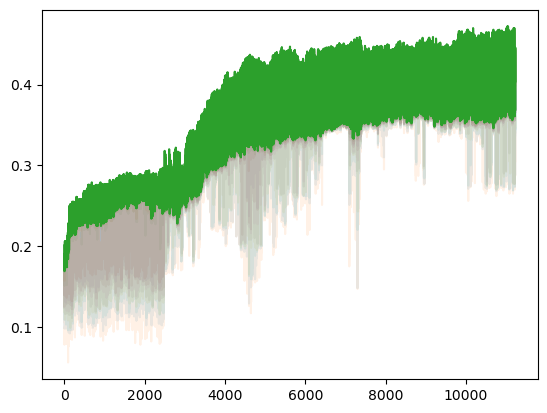

average best of last 100 generations 0.41058
generation 11231  test set: 7 evaluating performances|||||||||||| done!  best: 0.438 second: 0.437 third: 0.437
mutating in range: 0.016320700858343917
generation 11232  test set: 3 evaluating performances|||||||||||| done!  best: 0.383 second: 0.383 third: 0.382
mutating in range: 0.0009449997737776495
generation 11233  test set: 8 evaluating performances|||||||||||| done!  best: 0.465 second: 0.465 third: 0.465
mutating in range: 0.015214456323158333
generation 11234  test set: 3 evaluating performances|||||||||||| done!  best: 0.383 second: 0.383 third: 0.383
mutating in range: 0.026892854559971088
generation 11235  test set: 1 evaluating performances|||||||||||| done!  best: 0.36 second: 0.359 third: 0.359
mutating in range: 0.027300971210924542
generation 11236  test set: 7 evaluating performances|||||||||||| done!  best: 0.435 second: 0.435 third: 0.434
mutating in range: 0.04305351262656067
generation 11237  test set: 5 evaluating per

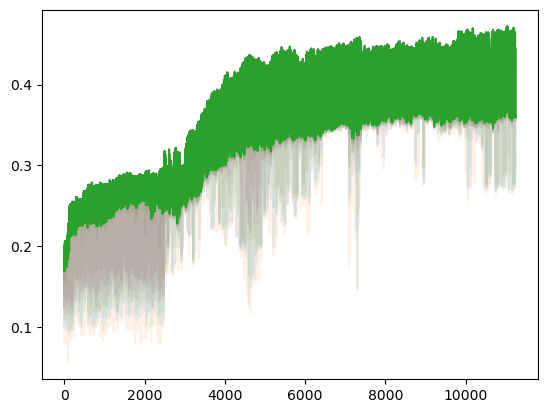

average best of last 100 generations 0.41027
generation 11241  test set: 4 evaluating performances|||||||||||| done!  best: 0.374 second: 0.374 third: 0.374
mutating in range: 0.04310158192834234
generation 11242  test set: 0 evaluating performances|||||||||||| done!  best: 0.401 second: 0.401 third: 0.4
mutating in range: 0.03418561544607307
generation 11243  test set: 4 evaluating performances|||||||||||| done!  best: 0.376 second: 0.374 third: 0.374
mutating in range: 0.036199563017983216
generation 11244  test set: 7 evaluating performances|||||||||||| done!  best: 0.444 second: 0.436 third: 0.436
mutating in range: 0.004570117899103265
generation 11245  test set: 6 evaluating performances|||||||||||| done!  best: 0.449 second: 0.448 third: 0.448
mutating in range: 0.031097495431491835
generation 11246  test set: 3 evaluating performances|||||||||||| done!  best: 0.383 second: 0.381 third: 0.38
mutating in range: 0.029883830785755645
generation 11247  test set: 1 evaluating perform

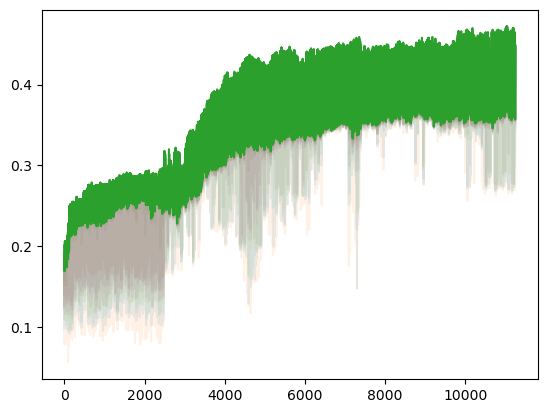

average best of last 100 generations 0.41009999999999996
generation 11251  test set: 3 evaluating performances|||||||||||| done!  best: 0.381 second: 0.381 third: 0.38
mutating in range: 0.046647054584923256
generation 11252  test set: 3 evaluating performances|||||||||||| done!  best: 0.383 second: 0.382 third: 0.381
mutating in range: 0.0478014779728058
generation 11253  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.383 third: 0.382
mutating in range: 0.039606252709241556
generation 11254  test set: 2 evaluating performances|||||||||||| done!  best: 0.372 second: 0.371 third: 0.369
mutating in range: 0.020925544790452406
generation 11255  test set: 1 evaluating performances|||||||||||| done!  best: 0.359 second: 0.358 third: 0.358
mutating in range: 0.03217646994833925
generation 11256  test set: 5 evaluating performances|||||||||||| done!  best: 0.448 second: 0.447 third: 0.444
mutating in range: 0.027985988406987183
generation 11257  test set: 8 evalu

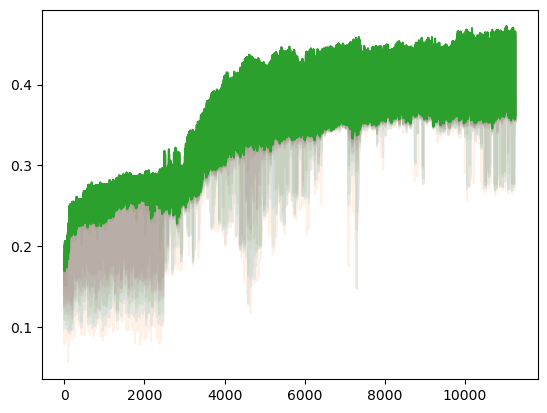

average best of last 100 generations 0.40925000000000006
generation 11261  test set: 1 evaluating performances|||||||||||| done!  best: 0.363 second: 0.361 third: 0.361
mutating in range: 0.028667948836625164
generation 11262  test set: 1 evaluating performances|||||||||||| done!  best: 0.366 second: 0.363 third: 0.363
mutating in range: 0.04553258956754065
generation 11263  test set: 3 evaluating performances|||||||||||| done!  best: 0.381 second: 0.38 third: 0.379
mutating in range: 0.0440144656707527
generation 11264  test set: 7 evaluating performances|||||||||||| done!  best: 0.433 second: 0.43 third: 0.429
mutating in range: 0.03366346467942449
generation 11265  test set: 8 evaluating performances|||||||||||| done!  best: 0.463 second: 0.463 third: 0.462
mutating in range: 0.02987597618725792
generation 11266  test set: 0 evaluating performances|||||||||||| done!  best: 0.401 second: 0.401 third: 0.4
mutating in range: 0.03052153744589103
generation 11267  test set: 5 evaluating 

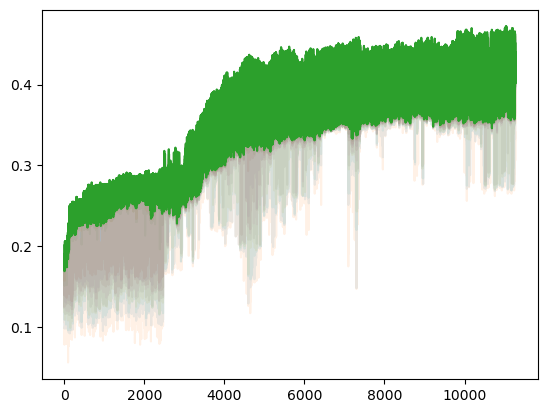

average best of last 100 generations 0.40915999999999997
generation 11271  test set: 4 evaluating performances|||||||||||| done!  best: 0.375 second: 0.375 third: 0.374
mutating in range: 0.028286946941188884
generation 11272  test set: 8 evaluating performances|||||||||||| done!  best: 0.467 second: 0.467 third: 0.465
mutating in range: 0.0252851692997281
generation 11273  test set: 2 evaluating performances|||||||||||| done!  best: 0.373 second: 0.372 third: 0.372
mutating in range: 0.020607151052638203
generation 11274  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.383 third: 0.383
mutating in range: 0.04867801306854896
generation 11275  test set: 8 evaluating performances|||||||||||| done!  best: 0.464 second: 0.464 third: 0.462
mutating in range: 0.00935507175403747
generation 11276  test set: 2 evaluating performances|||||||||||| done!  best: 0.375 second: 0.374 third: 0.374
mutating in range: 0.0476604803271885
generation 11277  test set: 3 evaluat

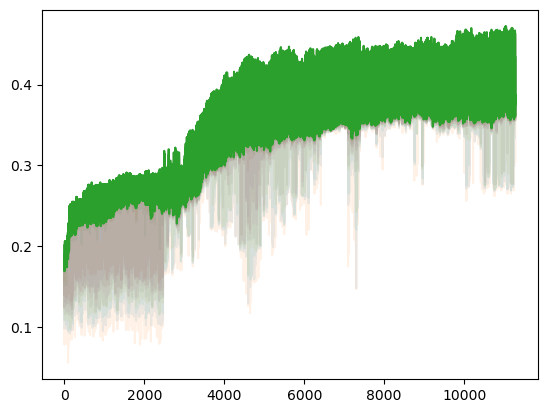

average best of last 100 generations 0.4106299999999999
generation 11281  test set: 5 evaluating performances|||||||||||| done!  best: 0.448 second: 0.447 third: 0.447
mutating in range: 0.006546558353817251
generation 11282  test set: 9 evaluating performances|||||||||||| done!  best: 0.436 second: 0.435 third: 0.434
mutating in range: 0.04178510468416807
generation 11283  test set: 7 evaluating performances|||||||||||| done!  best: 0.43 second: 0.428 third: 0.428
mutating in range: 0.04214272364639849
generation 11284  test set: 2 evaluating performances|||||||||||| done!  best: 0.378 second: 0.378 third: 0.377
mutating in range: 0.03351376907707087
generation 11285  test set: 6 evaluating performances|||||||||||| done!  best: 0.442 second: 0.44 third: 0.44
mutating in range: 0.03722368219521646
generation 11286  test set: 0 evaluating performances|||||||||||| done!  best: 0.408 second: 0.407 third: 0.407
mutating in range: 0.034139271849524956
generation 11287  test set: 8 evaluatin

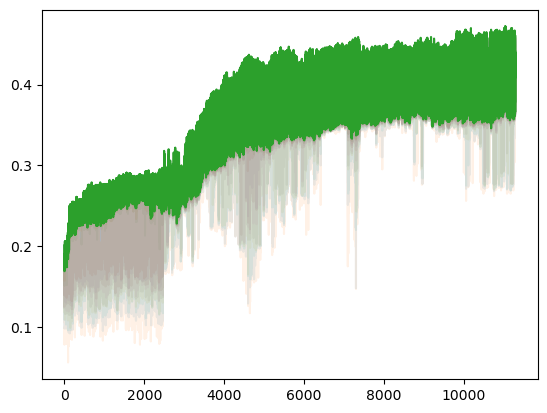

average best of last 100 generations 0.4103299999999999
generation 11291  test set: 2 evaluating performances|||||||||||| done!  best: 0.374 second: 0.374 third: 0.374
mutating in range: 0.0008306152192157079
generation 11292  test set: 2 evaluating performances|||||||||||| done!  best: 0.374 second: 0.374 third: 0.374
mutating in range: 0.009602984721220521
generation 11293  test set: 8 evaluating performances|||||||||||| done!  best: 0.467 second: 0.467 third: 0.466
mutating in range: 0.020255602684544235
generation 11294  test set: 2 evaluating performances|||||||||||| done!  best: 0.375 second: 0.374 third: 0.374
mutating in range: 0.03924283203397014
generation 11295  test set: 1 evaluating performances|||||||||||| done!  best: 0.364 second: 0.364 third: 0.364
mutating in range: 0.00964600771428164
generation 11296  test set: 2 evaluating performances|||||||||||| done!  best: 0.375 second: 0.375 third: 0.374
mutating in range: 0.02120477692602614
generation 11297  test set: 8 eval

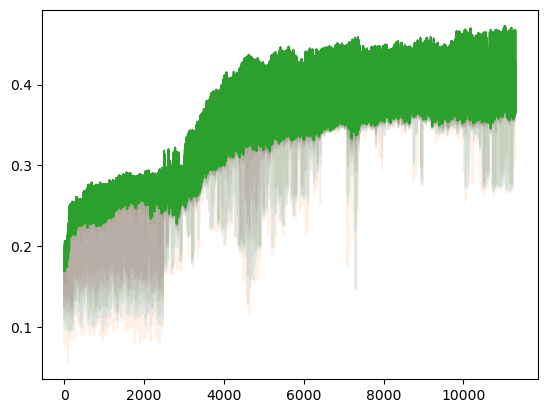

average best of last 100 generations 0.4094400000000001
generation 11301  test set: 7 evaluating performances|||||||||||| done!  best: 0.428 second: 0.427 third: 0.427
mutating in range: 0.04027456095144036
generation 11302  test set: 6 evaluating performances|||||||||||| done!  best: 0.444 second: 0.443 third: 0.442
mutating in range: 0.016918700241384834
generation 11303  test set: 0 evaluating performances|||||||||||| done!  best: 0.405 second: 0.403 third: 0.403
mutating in range: 0.01740906960948483
generation 11304  test set: 3 evaluating performances|||||||||||| done!  best: 0.388 second: 0.388 third: 0.388
mutating in range: 0.0316418755505238
generation 11305  test set: 7 evaluating performances|||||||||||| done!  best: 0.429 second: 0.427 third: 0.426
mutating in range: 0.004270603037243542
generation 11306  test set: 0 evaluating performances|||||||||||| done!  best: 0.403 second: 0.403 third: 0.402
mutating in range: 0.040292974854429495
generation 11307  test set: 7 evalua

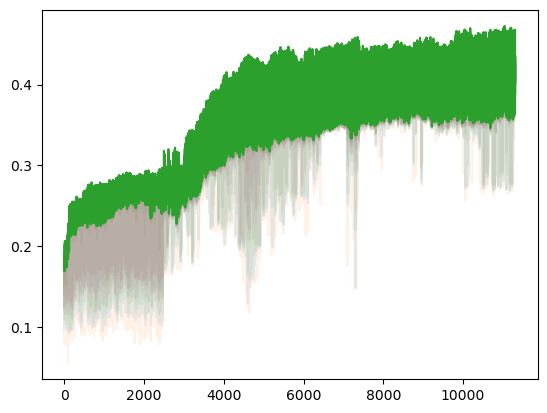

average best of last 100 generations 0.40891000000000005
generation 11311  test set: 3 evaluating performances|||||||||||| done!  best: 0.388 second: 0.388 third: 0.388
mutating in range: 0.04020086749308173
generation 11312  test set: 9 evaluating performances|||||||||||| done!  best: 0.438 second: 0.437 third: 0.437
mutating in range: 0.007559651313632182
generation 11313  test set: 5 evaluating performances|||||||||||| done!  best: 0.445 second: 0.444 third: 0.444
mutating in range: 0.024393795053073486
generation 11314  test set: 6 evaluating performances|||||||||||| done!  best: 0.446 second: 0.444 third: 0.444
mutating in range: 0.049612734724121546
generation 11315  test set: 1 evaluating performances|||||||||||| done!  best: 0.371 second: 0.37 third: 0.37
mutating in range: 0.04375608958989092
generation 11316  test set: 4 evaluating performances|||||||||||| done!  best: 0.375 second: 0.374 third: 0.373
mutating in range: 0.0033183806796612983
generation 11317  test set: 6 eval

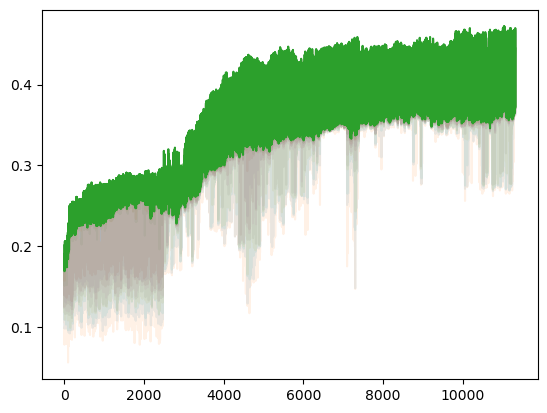

average best of last 100 generations 0.41068999999999994
generation 11321  test set: 6 evaluating performances|||||||||||| done!  best: 0.448 second: 0.445 third: 0.445
mutating in range: 0.013656872420132637
generation 11322  test set: 7 evaluating performances|||||||||||| done!  best: 0.435 second: 0.435 third: 0.433
mutating in range: 0.02127576838319552
generation 11323  test set: 3 evaluating performances|||||||||||| done!  best: 0.385 second: 0.384 third: 0.384
mutating in range: 0.029651804122905242
generation 11324  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.436 third: 0.436
mutating in range: 0.020530347935864904
generation 11325  test set: 6 evaluating performances|||||||||||| done!  best: 0.446 second: 0.444 third: 0.443
mutating in range: 0.000845459517300673
generation 11326  test set: 1 evaluating performances|||||||||||| done!  best: 0.368 second: 0.367 third: 0.367
mutating in range: 0.02795570481491243
generation 11327  test set: 4 eva

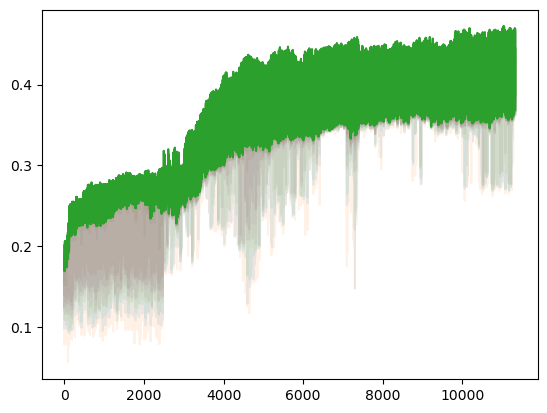

average best of last 100 generations 0.41190000000000004
generation 11331  test set: 1 evaluating performances|||||||||||| done!  best: 0.369 second: 0.367 third: 0.367
mutating in range: 0.04204427084057858
generation 11332  test set: 7 evaluating performances|||||||||||| done!  best: 0.439 second: 0.437 third: 0.437
mutating in range: 0.019189633649410294
generation 11333  test set: 1 evaluating performances|||||||||||| done!  best: 0.369 second: 0.369 third: 0.368
mutating in range: 0.03192906139341019
generation 11334  test set: 8 evaluating performances|||||||||||| done!  best: 0.47 second: 0.469 third: 0.467
mutating in range: 0.015592068407045846
generation 11335  test set: 8 evaluating performances|||||||||||| done!  best: 0.47 second: 0.47 third: 0.469
mutating in range: 0.02405958829836413
generation 11336  test set: 7 evaluating performances|||||||||||| done!  best: 0.438 second: 0.436 third: 0.435
mutating in range: 0.008011220723017165
generation 11337  test set: 8 evaluat

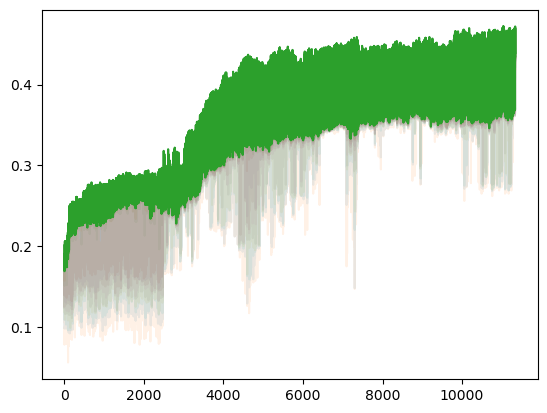

average best of last 100 generations 0.41455000000000003
generation 11341  test set: 1 evaluating performances|||||||||||| done!  best: 0.368 second: 0.368 third: 0.368
mutating in range: 0.0389148508134225
generation 11342  test set: 4 evaluating performances|||||||||||| done!  best: 0.374 second: 0.372 third: 0.372
mutating in range: 0.01839221482654313
generation 11343  test set: 5 evaluating performances|||||||||||| done!  best: 0.443 second: 0.442 third: 0.442
mutating in range: 0.028643881187023414
generation 11344  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.384 third: 0.382
mutating in range: 0.005626656464797409
generation 11345  test set: 3 evaluating performances|||||||||||| done!  best: 0.385 second: 0.384 third: 0.384
mutating in range: 0.01490312980290477
generation 11346  test set: 5 evaluating performances|||||||||||| done!  best: 0.444 second: 0.444 third: 0.443
mutating in range: 0.04939829729505049
generation 11347  test set: 4 evalua

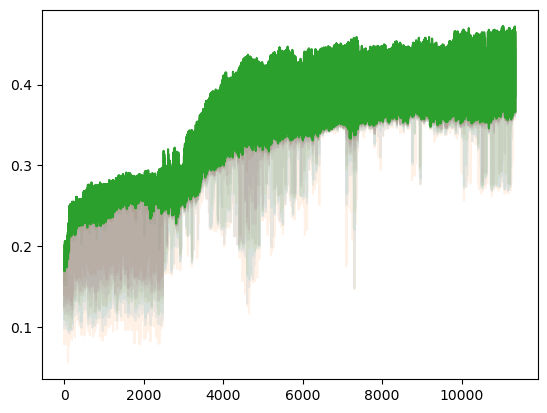

average best of last 100 generations 0.41375999999999996
generation 11351  test set: 0 evaluating performances|||||||||||| done!  best: 0.399 second: 0.398 third: 0.397
mutating in range: 0.005766931374224277
generation 11352  test set: 9 evaluating performances|||||||||||| done!  best: 0.433 second: 0.433 third: 0.433
mutating in range: 0.029640420775651394
generation 11353  test set: 2 evaluating performances|||||||||||| done!  best: 0.372 second: 0.371 third: 0.37
mutating in range: 0.045843234786297024
generation 11354  test set: 0 evaluating performances|||||||||||| done!  best: 0.4 second: 0.398 third: 0.398
mutating in range: 0.02553905997586849
generation 11355  test set: 1 evaluating performances|||||||||||| done!  best: 0.365 second: 0.365 third: 0.364
mutating in range: 0.027377599646794988
generation 11356  test set: 9 evaluating performances|||||||||||| done!  best: 0.438 second: 0.438 third: 0.437
mutating in range: 0.04907052898445534
generation 11357  test set: 1 evalua

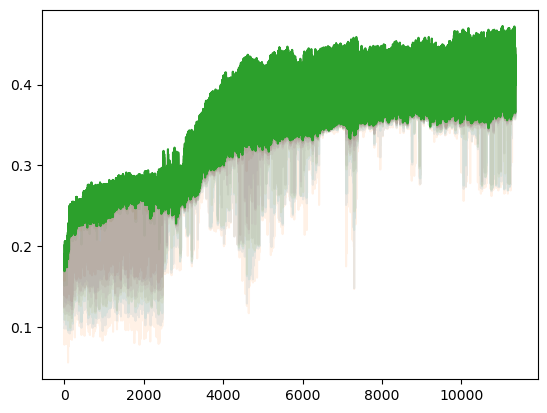

average best of last 100 generations 0.41434
generation 11361  test set: 5 evaluating performances|||||||||||| done!  best: 0.443 second: 0.441 third: 0.44
mutating in range: 0.03814162431985409
generation 11362  test set: 2 evaluating performances|||||||||||| done!  best: 0.371 second: 0.37 third: 0.369
mutating in range: 0.018243970268703485
generation 11363  test set: 0 evaluating performances|||||||||||| done!  best: 0.399 second: 0.399 third: 0.399
mutating in range: 0.015489349526589487
generation 11364  test set: 3 evaluating performances|||||||||||| done!  best: 0.378 second: 0.378 third: 0.378
mutating in range: 0.025667748042885893
generation 11365  test set: 4 evaluating performances|||||||||||| done!  best: 0.374 second: 0.372 third: 0.372
mutating in range: 0.04351944658586346
generation 11366  test set: 7 evaluating performances|||||||||||| done!  best: 0.441 second: 0.439 third: 0.437
mutating in range: 0.015203687022300284
generation 11367  test set: 7 evaluating perfor

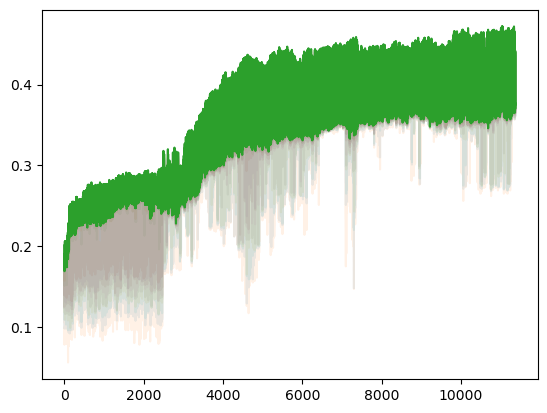

average best of last 100 generations 0.41340000000000005
generation 11371  test set: 8 evaluating performances|||||||||||| done!  best: 0.465 second: 0.464 third: 0.463
mutating in range: 0.04768488546191914
generation 11372  test set: 2 evaluating performances|||||||||||| done!  best: 0.37 second: 0.367 third: 0.367
mutating in range: 0.029244583235727817
generation 11373  test set: 1 evaluating performances|||||||||||| done!  best: 0.361 second: 0.36 third: 0.359
mutating in range: 0.039004013188898866
generation 11374  test set: 4 evaluating performances|||||||||||| done!  best: 0.374 second: 0.372 third: 0.371
mutating in range: 0.025107956477321787
generation 11375  test set: 6 evaluating performances|||||||||||| done!  best: 0.443 second: 0.442 third: 0.442
mutating in range: 0.009513512976879142
generation 11376  test set: 0 evaluating performances|||||||||||| done!  best: 0.397 second: 0.396 third: 0.396
mutating in range: 0.017528546882404582
generation 11377  test set: 8 eval

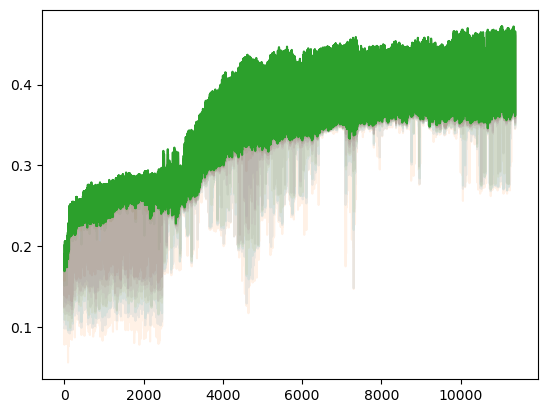

average best of last 100 generations 0.41422999999999993
generation 11381  test set: 2 evaluating performances|||||||||||| done!  best: 0.37 second: 0.369 third: 0.369
mutating in range: 0.03825175296586114
generation 11382  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.381 third: 0.378
mutating in range: 0.017190323941978985
generation 11383  test set: 7 evaluating performances|||||||||||| done!  best: 0.434 second: 0.434 third: 0.433
mutating in range: 0.030090906513410672
generation 11384  test set: 0 evaluating performances|||||||||||| done!  best: 0.396 second: 0.395 third: 0.395
mutating in range: 0.023084001169582063
generation 11385  test set: 6 evaluating performances|||||||||||| done!  best: 0.444 second: 0.442 third: 0.442
mutating in range: 0.043703213142880934
generation 11386  test set: 0 evaluating performances|||||||||||| done!  best: 0.397 second: 0.396 third: 0.395
mutating in range: 0.0454205022338974
generation 11387  test set: 7 evalu

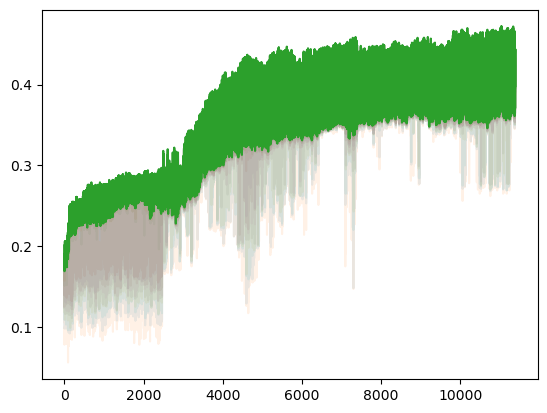

average best of last 100 generations 0.41352000000000005
generation 11391  test set: 7 evaluating performances|||||||||||| done!  best: 0.442 second: 0.442 third: 0.442
mutating in range: 4.140786423654786e-05
generation 11392  test set: 3 evaluating performances|||||||||||| done!  best: 0.374 second: 0.374 third: 0.374
mutating in range: 0.017812339072113326
generation 11393  test set: 7 evaluating performances|||||||||||| done!  best: 0.442 second: 0.442 third: 0.442
mutating in range: 0.023355411406839267
generation 11394  test set: 6 evaluating performances|||||||||||| done!  best: 0.448 second: 0.446 third: 0.444
mutating in range: 0.04496242531484346
generation 11395  test set: 4 evaluating performances|||||||||||| done!  best: 0.375 second: 0.374 third: 0.374
mutating in range: 0.03139511011726597
generation 11396  test set: 8 evaluating performances|||||||||||| done!  best: 0.47 second: 0.47 third: 0.469
mutating in range: 0.042427677370055594
generation 11397  test set: 0 eval

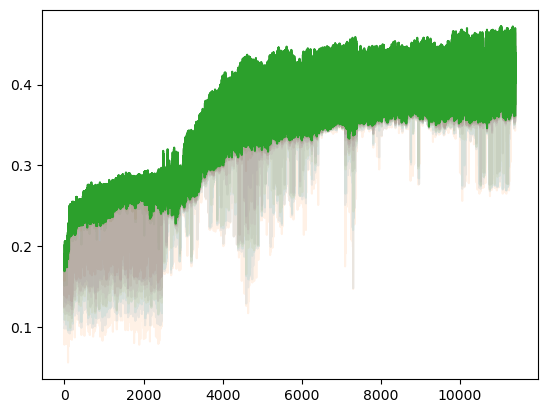

average best of last 100 generations 0.4154100000000001
generation 11401  test set: 2 evaluating performances|||||||||||| done!  best: 0.373 second: 0.372 third: 0.37
mutating in range: 0.014101166962066808
generation 11402  test set: 6 evaluating performances|||||||||||| done!  best: 0.447 second: 0.442 third: 0.441
mutating in range: 0.009140248819884107
generation 11403  test set: 6 evaluating performances|||||||||||| done!  best: 0.447 second: 0.445 third: 0.444
mutating in range: 0.024991694957289368
generation 11404  test set: 7 evaluating performances|||||||||||| done!  best: 0.444 second: 0.444 third: 0.443
mutating in range: 0.01597290728868971
generation 11405  test set: 8 evaluating performances|||||||||||| done!  best: 0.467 second: 0.465 third: 0.465
mutating in range: 0.0312669199905646
generation 11406  test set: 6 evaluating performances|||||||||||| done!  best: 0.442 second: 0.442 third: 0.441
mutating in range: 0.044254277874053886
generation 11407  test set: 5 evalua

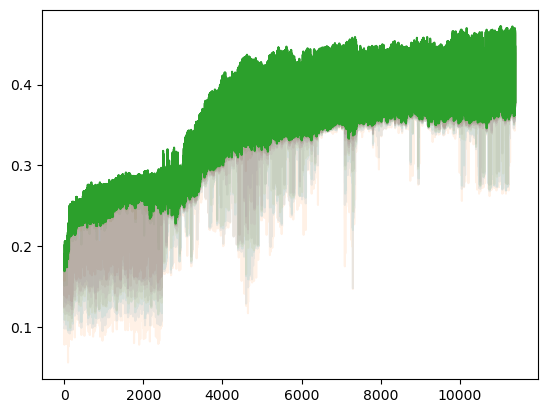

average best of last 100 generations 0.41600000000000004
generation 11411  test set: 3 evaluating performances|||||||||||| done!  best: 0.378 second: 0.377 third: 0.377
mutating in range: 0.03570581059972019
generation 11412  test set: 7 evaluating performances|||||||||||| done!  best: 0.447 second: 0.446 third: 0.445
mutating in range: 0.026244376825333888
generation 11413  test set: 1 evaluating performances|||||||||||| done!  best: 0.363 second: 0.363 third: 0.363
mutating in range: 0.008265021749239116
generation 11414  test set: 4 evaluating performances|||||||||||| done!  best: 0.378 second: 0.377 third: 0.376
mutating in range: 0.04637652670110973
generation 11415  test set: 7 evaluating performances|||||||||||| done!  best: 0.447 second: 0.441 third: 0.44
mutating in range: 0.048879272639335745
generation 11416  test set: 2 evaluating performances|||||||||||| done!  best: 0.369 second: 0.369 third: 0.368
mutating in range: 0.03432011729578995
generation 11417  test set: 6 evalu

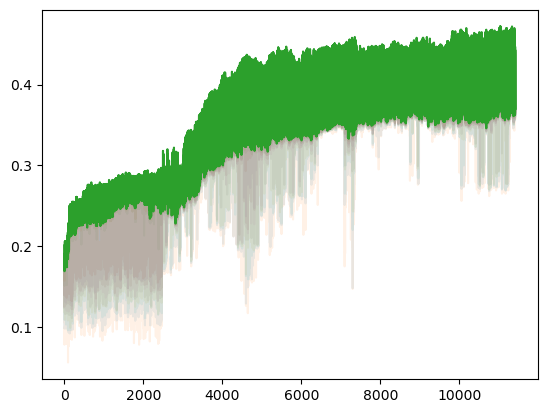

average best of last 100 generations 0.4133099999999999
generation 11421  test set: 7 evaluating performances|||||||||||| done!  best: 0.439 second: 0.439 third: 0.439
mutating in range: 0.02628684315670169
generation 11422  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.437 third: 0.436
mutating in range: 0.03659236926091261
generation 11423  test set: 8 evaluating performances|||||||||||| done!  best: 0.47 second: 0.47 third: 0.467
mutating in range: 0.03788955212476565
generation 11424  test set: 5 evaluating performances|||||||||||| done!  best: 0.446 second: 0.445 third: 0.442
mutating in range: 0.0498990598738106
generation 11425  test set: 1 evaluating performances|||||||||||| done!  best: 0.363 second: 0.363 third: 0.361
mutating in range: 0.03572972294604964
generation 11426  test set: 7 evaluating performances|||||||||||| done!  best: 0.441 second: 0.439 third: 0.439
mutating in range: 0.01916118378228228
generation 11427  test set: 5 evaluating 

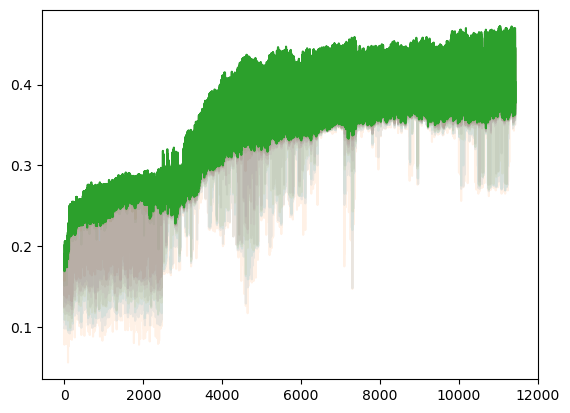

average best of last 100 generations 0.41359999999999997
generation 11431  test set: 2 evaluating performances|||||||||||| done!  best: 0.376 second: 0.376 third: 0.375
mutating in range: 0.0275393109789304
generation 11432  test set: 6 evaluating performances|||||||||||| done!  best: 0.447 second: 0.443 third: 0.443
mutating in range: 0.0227051836071403
generation 11433  test set: 2 evaluating performances|||||||||||| done!  best: 0.375 second: 0.375 third: 0.374
mutating in range: 0.011933068961391735
generation 11434  test set: 4 evaluating performances|||||||||||| done!  best: 0.378 second: 0.377 third: 0.377
mutating in range: 0.01025096994530862
generation 11435  test set: 0 evaluating performances|||||||||||| done!  best: 0.406 second: 0.405 third: 0.405
mutating in range: 0.03821400593964582
generation 11436  test set: 4 evaluating performances|||||||||||| done!  best: 0.378 second: 0.378 third: 0.378
mutating in range: 0.03720581636919039
generation 11437  test set: 0 evaluati

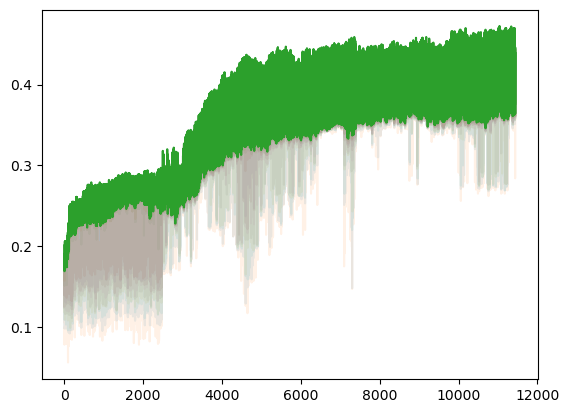

average best of last 100 generations 0.41037999999999997
generation 11441  test set: 0 evaluating performances|||||||||||| done!  best: 0.406 second: 0.404 third: 0.403
mutating in range: 0.005083890820058751
generation 11442  test set: 2 evaluating performances|||||||||||| done!  best: 0.374 second: 0.374 third: 0.374
mutating in range: 0.01498372686122524
generation 11443  test set: 2 evaluating performances|||||||||||| done!  best: 0.375 second: 0.374 third: 0.374
mutating in range: 0.00026481181403337217
generation 11444  test set: 1 evaluating performances|||||||||||| done!  best: 0.364 second: 0.364 third: 0.364
mutating in range: 0.015222523970486252
generation 11445  test set: 3 evaluating performances|||||||||||| done!  best: 0.376 second: 0.375 third: 0.374
mutating in range: 0.021565887890196218
generation 11446  test set: 7 evaluating performances|||||||||||| done!  best: 0.438 second: 0.438 third: 0.437
mutating in range: 0.03593346115747827
generation 11447  test set: 9 e

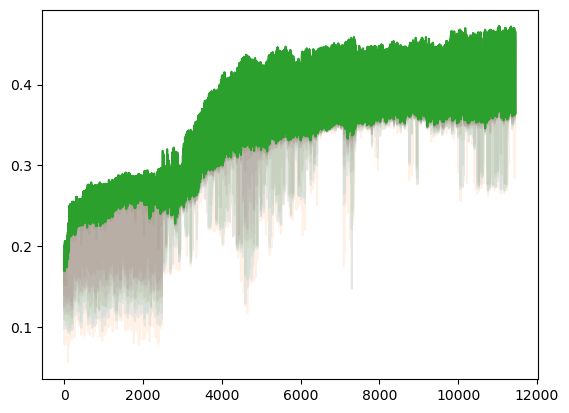

average best of last 100 generations 0.41035
generation 11451  test set: 6 evaluating performances|||||||||||| done!  best: 0.445 second: 0.445 third: 0.444
mutating in range: 0.008269899983710206
generation 11452  test set: 5 evaluating performances|||||||||||| done!  best: 0.446 second: 0.445 third: 0.445
mutating in range: 0.008054536086052761
generation 11453  test set: 7 evaluating performances|||||||||||| done!  best: 0.433 second: 0.433 third: 0.432
mutating in range: 0.04677255867586628
generation 11454  test set: 2 evaluating performances|||||||||||| done!  best: 0.374 second: 0.373 third: 0.372
mutating in range: 0.012241579394319357
generation 11455  test set: 0 evaluating performances|||||||||||| done!  best: 0.406 second: 0.404 third: 0.404
mutating in range: 0.0344792103858446
generation 11456  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.436 third: 0.436
mutating in range: 0.027919837558301748
generation 11457  test set: 8 evaluating perfo

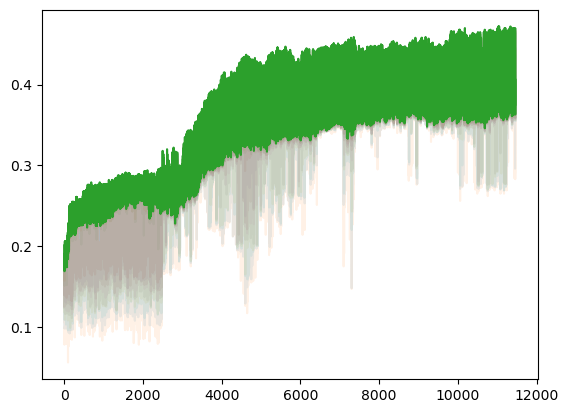

average best of last 100 generations 0.4114
generation 11461  test set: 3 evaluating performances|||||||||||| done!  best: 0.381 second: 0.375 third: 0.375
mutating in range: 0.013852056368547151
generation 11462  test set: 2 evaluating performances|||||||||||| done!  best: 0.372 second: 0.372 third: 0.372
mutating in range: 0.011698536471071686
generation 11463  test set: 3 evaluating performances|||||||||||| done!  best: 0.377 second: 0.377 third: 0.376
mutating in range: 0.01605843244953107
generation 11464  test set: 9 evaluating performances|||||||||||| done!  best: 0.438 second: 0.437 third: 0.435
mutating in range: 0.042624802292864444
generation 11465  test set: 0 evaluating performances|||||||||||| done!  best: 0.406 second: 0.406 third: 0.405
mutating in range: 0.022826253509744116
generation 11466  test set: 3 evaluating performances|||||||||||| done!  best: 0.377 second: 0.375 third: 0.374
mutating in range: 0.010512762568405765
generation 11467  test set: 4 evaluating perf

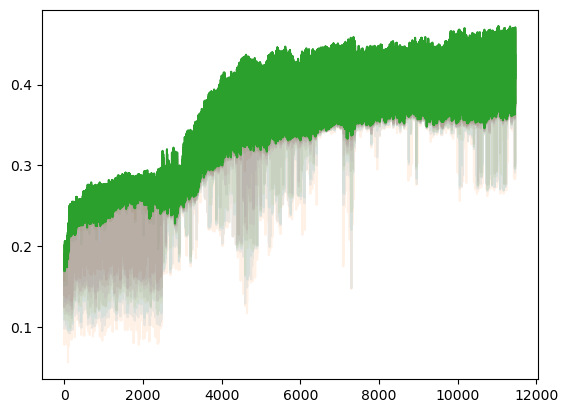

average best of last 100 generations 0.4106699999999999
generation 11471  test set: 8 evaluating performances|||||||||||| done!  best: 0.471 second: 0.47 third: 0.47
mutating in range: 0.04501870946877345
generation 11472  test set: 6 evaluating performances|||||||||||| done!  best: 0.442 second: 0.439 third: 0.439
mutating in range: 0.04820583514607505
generation 11473  test set: 1 evaluating performances|||||||||||| done!  best: 0.362 second: 0.362 third: 0.361
mutating in range: 0.046567515690938005
generation 11474  test set: 6 evaluating performances|||||||||||| done!  best: 0.443 second: 0.442 third: 0.439
mutating in range: 0.03815920343648294
generation 11475  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.438 third: 0.437
mutating in range: 0.04184914255324402
generation 11476  test set: 8 evaluating performances|||||||||||| done!  best: 0.47 second: 0.463 third: 0.463
mutating in range: 0.03578697259580222
generation 11477  test set: 7 evaluating

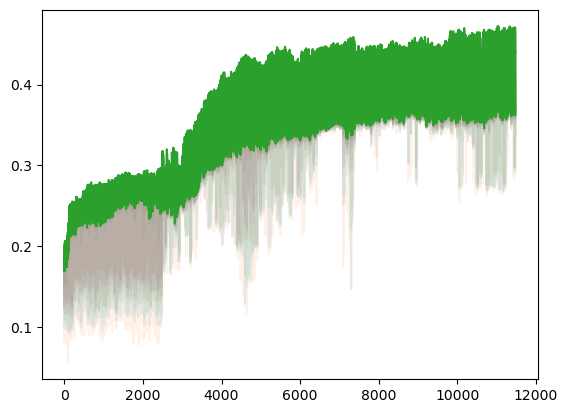

average best of last 100 generations 0.41190000000000004
generation 11481  test set: 0 evaluating performances|||||||||||| done!  best: 0.405 second: 0.403 third: 0.402
mutating in range: 0.034626400377576284
generation 11482  test set: 3 evaluating performances|||||||||||| done!  best: 0.378 second: 0.376 third: 0.376
mutating in range: 0.04787373254662594
generation 11483  test set: 0 evaluating performances|||||||||||| done!  best: 0.403 second: 0.403 third: 0.401
mutating in range: 0.008123291328544113
generation 11484  test set: 7 evaluating performances|||||||||||| done!  best: 0.43 second: 0.429 third: 0.429
mutating in range: 0.04373885315624011
generation 11485  test set: 8 evaluating performances|||||||||||| done!  best: 0.464 second: 0.463 third: 0.462
mutating in range: 0.003099458007141709
generation 11486  test set: 3 evaluating performances|||||||||||| done!  best: 0.381 second: 0.381 third: 0.381
mutating in range: 0.021464521723978332
generation 11487  test set: 4 eval

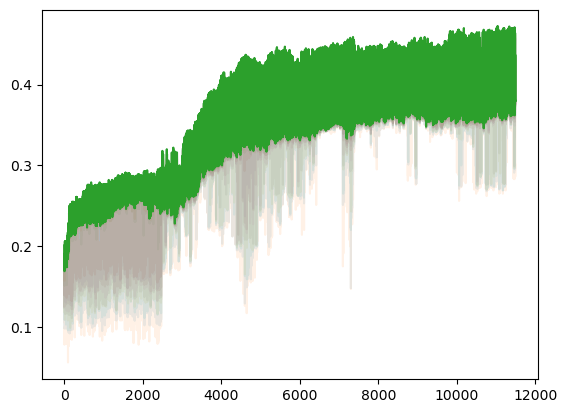

average best of last 100 generations 0.4110999999999999
generation 11491  test set: 3 evaluating performances|||||||||||| done!  best: 0.38 second: 0.379 third: 0.378
mutating in range: 0.006923860897620294
generation 11492  test set: 2 evaluating performances|||||||||||| done!  best: 0.369 second: 0.368 third: 0.368
mutating in range: 0.002744651338807447
generation 11493  test set: 0 evaluating performances|||||||||||| done!  best: 0.406 second: 0.406 third: 0.405
mutating in range: 0.03584336868044965
generation 11494  test set: 6 evaluating performances|||||||||||| done!  best: 0.441 second: 0.441 third: 0.44
mutating in range: 0.043615387903612364
generation 11495  test set: 9 evaluating performances|||||||||||| done!  best: 0.44 second: 0.44 third: 0.44
mutating in range: 0.04854086265163307
generation 11496  test set: 0 evaluating performances|||||||||||| done!  best: 0.405 second: 0.403 third: 0.398
mutating in range: 0.022584185550982617
generation 11497  test set: 3 evaluatin

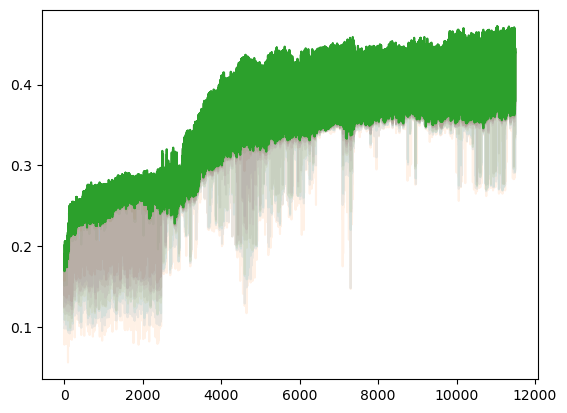

average best of last 100 generations 0.41104
generation 11501  test set: 3 evaluating performances|||||||||||| done!  best: 0.377 second: 0.376 third: 0.375
mutating in range: 0.03309856230498638
generation 11502  test set: 8 evaluating performances|||||||||||| done!  best: 0.467 second: 0.465 third: 0.464
mutating in range: 0.0026768367954466635
generation 11503  test set: 4 evaluating performances|||||||||||| done!  best: 0.376 second: 0.375 third: 0.375
mutating in range: 0.010249373615817486
generation 11504  test set: 0 evaluating performances|||||||||||| done!  best: 0.398 second: 0.398 third: 0.398
mutating in range: 0.017650010732788237
generation 11505  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.439 third: 0.439
mutating in range: 0.0423856016515016
generation 11506  test set: 4 evaluating performances|||||||||||| done!  best: 0.376 second: 0.376 third: 0.374
mutating in range: 0.0186912138404176
generation 11507  test set: 2 evaluating perfor

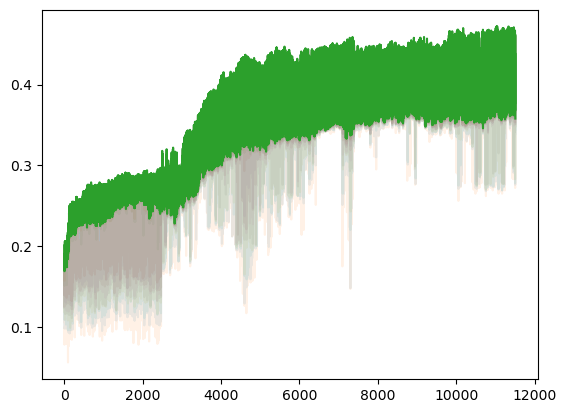

average best of last 100 generations 0.40814000000000006
generation 11511  test set: 8 evaluating performances|||||||||||| done!  best: 0.461 second: 0.461 third: 0.461
mutating in range: 0.0346715709630975
generation 11512  test set: 2 evaluating performances|||||||||||| done!  best: 0.368 second: 0.368 third: 0.368
mutating in range: 0.019449210717931088
generation 11513  test set: 7 evaluating performances|||||||||||| done!  best: 0.434 second: 0.433 third: 0.432
mutating in range: 0.04659440982280403
generation 11514  test set: 9 evaluating performances|||||||||||| done!  best: 0.437 second: 0.435 third: 0.434
mutating in range: 0.04803273704391803
generation 11515  test set: 2 evaluating performances|||||||||||| done!  best: 0.37 second: 0.368 third: 0.367
mutating in range: 0.004498276036031396
generation 11516  test set: 9 evaluating performances|||||||||||| done!  best: 0.438 second: 0.437 third: 0.437
mutating in range: 0.004870394967499365
generation 11517  test set: 1 evalua

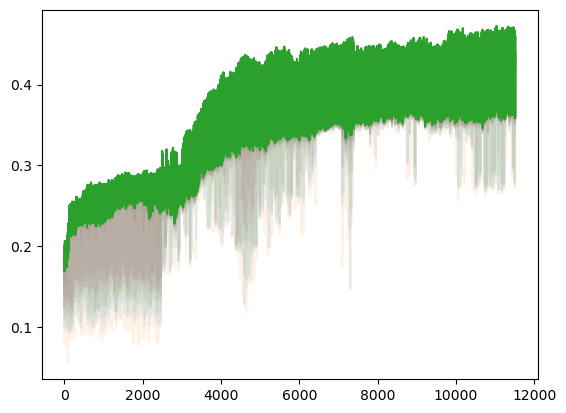

average best of last 100 generations 0.41002000000000005
generation 11521  test set: 3 evaluating performances|||||||||||| done!  best: 0.374 second: 0.372 third: 0.371
mutating in range: 0.017714001534504416
generation 11522  test set: 2 evaluating performances|||||||||||| done!  best: 0.368 second: 0.368 third: 0.368
mutating in range: 0.008943830487186171
generation 11523  test set: 1 evaluating performances|||||||||||| done!  best: 0.359 second: 0.359 third: 0.358
mutating in range: 0.02720169938547705
generation 11524  test set: 4 evaluating performances|||||||||||| done!  best: 0.374 second: 0.374 third: 0.374
mutating in range: 0.007110990298114761
generation 11525  test set: 5 evaluating performances|||||||||||| done!  best: 0.447 second: 0.447 third: 0.446
mutating in range: 0.017179201829019383
generation 11526  test set: 0 evaluating performances|||||||||||| done!  best: 0.402 second: 0.401 third: 0.401
mutating in range: 0.027130946599181468
generation 11527  test set: 8 ev

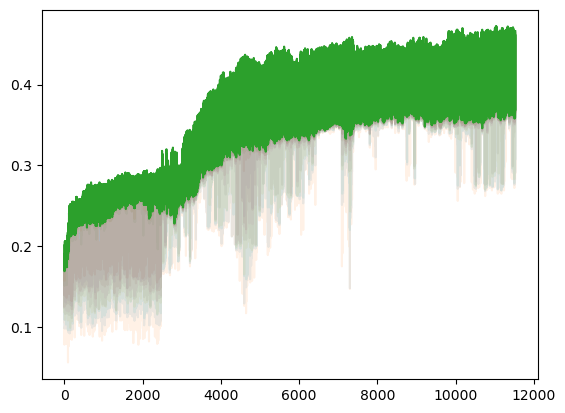

average best of last 100 generations 0.40757000000000004
generation 11531  test set: 4 evaluating performances|||||||||||| done!  best: 0.376 second: 0.375 third: 0.374
mutating in range: 0.013316230015868374
generation 11532  test set: 8 evaluating performances|||||||||||| done!  best: 0.468 second: 0.467 third: 0.466
mutating in range: 0.029738223856277276
generation 11533  test set: 7 evaluating performances|||||||||||| done!  best: 0.435 second: 0.433 third: 0.432
mutating in range: 0.003566353257717825
generation 11534  test set: 2 evaluating performances|||||||||||| done!  best: 0.368 second: 0.367 third: 0.365
mutating in range: 0.040291270941392815
generation 11535  test set: 5 evaluating performances|||||||||||| done!  best: 0.444 second: 0.443 third: 0.443
mutating in range: 0.014525959707711306
generation 11536  test set: 2 evaluating performances|||||||||||| done!  best: 0.369 second: 0.367 third: 0.367
mutating in range: 0.02913816911967067
generation 11537  test set: 2 ev

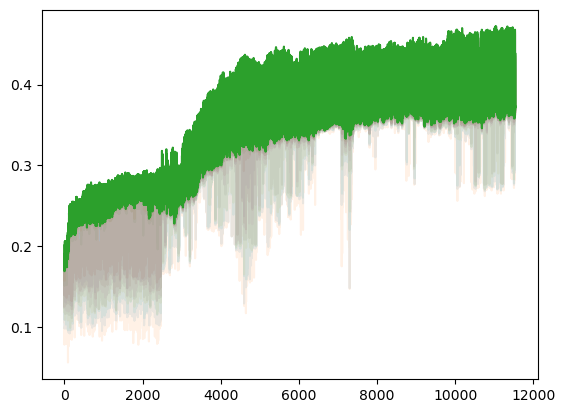

average best of last 100 generations 0.40754000000000007
generation 11541  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.438 third: 0.438
mutating in range: 0.008392878432900925
generation 11542  test set: 6 evaluating performances|||||||||||| done!  best: 0.447 second: 0.446 third: 0.446
mutating in range: 0.033724243143580065
generation 11543  test set: 6 evaluating performances|||||||||||| done!  best: 0.448 second: 0.447 third: 0.447
mutating in range: 0.036505586616775075
generation 11544  test set: 7 evaluating performances|||||||||||| done!  best: 0.436 second: 0.434 third: 0.434
mutating in range: 0.04071940840717034
generation 11545  test set: 1 evaluating performances|||||||||||| done!  best: 0.36 second: 0.36 third: 0.358
mutating in range: 0.014037891829232697
generation 11546  test set: 3 evaluating performances|||||||||||| done!  best: 0.374 second: 0.372 third: 0.372
mutating in range: 0.03957258648476647
generation 11547  test set: 0 evalu

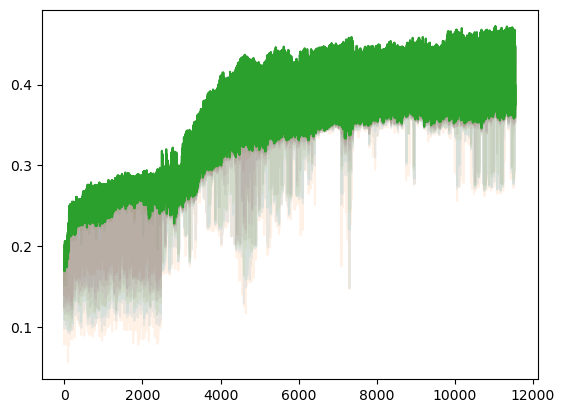

average best of last 100 generations 0.40871
generation 11551  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.439 third: 0.439
mutating in range: 0.021329593410007494
generation 11552  test set: 0 evaluating performances|||||||||||| done!  best: 0.402 second: 0.401 third: 0.401
mutating in range: 0.024519768458484022
generation 11553  test set: 8 evaluating performances|||||||||||| done!  best: 0.47 second: 0.47 third: 0.469
mutating in range: 0.04655850001126355
generation 11554  test set: 5 evaluating performances|||||||||||| done!  best: 0.446 second: 0.445 third: 0.443
mutating in range: 0.02574577675685998
generation 11555  test set: 6 evaluating performances|||||||||||| done!  best: 0.447 second: 0.446 third: 0.445
mutating in range: 0.041898997660560995
generation 11556  test set: 2 evaluating performances|||||||||||| done!  best: 0.371 second: 0.371 third: 0.369
mutating in range: 0.013374126859195158
generation 11557  test set: 1 evaluating perfor

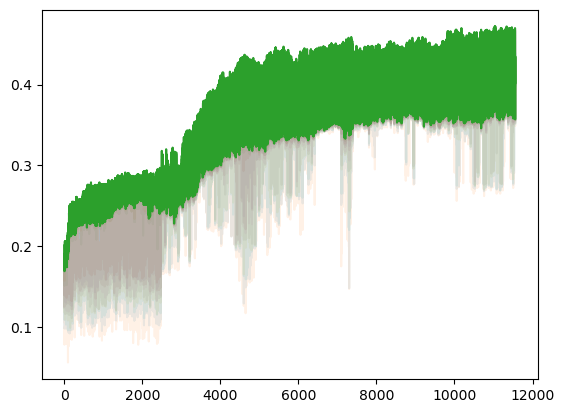

average best of last 100 generations 0.40857
generation 11561  test set: 6 evaluating performances|||||||||||| done!  best: 0.446 second: 0.445 third: 0.443
mutating in range: 0.01564181706349333
generation 11562  test set: 2 evaluating performances|||||||||||| done!  best: 0.371 second: 0.37 third: 0.37
mutating in range: 0.0119855627330843
generation 11563  test set: 7 evaluating performances|||||||||||| done!  best: 0.436 second: 0.434 third: 0.434
mutating in range: 0.03306029167827245
generation 11564  test set: 9 evaluating performances|||||||||||| done!  best: 0.44 second: 0.439 third: 0.438
mutating in range: 0.02981734520643291
generation 11565  test set: 7 evaluating performances|||||||||||| done!  best: 0.435 second: 0.434 third: 0.434
mutating in range: 0.003386013847069086
generation 11566  test set: 0 evaluating performances|||||||||||| done!  best: 0.399 second: 0.399 third: 0.399
mutating in range: 0.017696363699760194
generation 11567  test set: 6 evaluating performanc

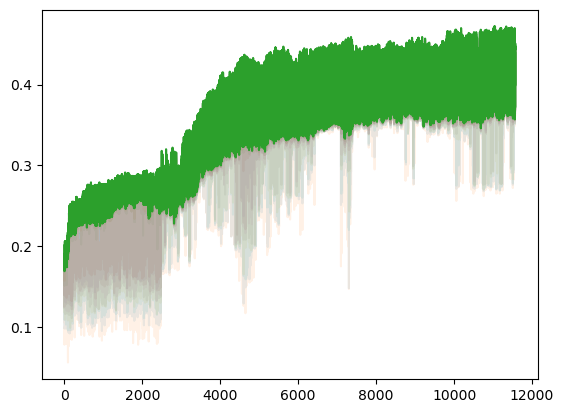

average best of last 100 generations 0.4111499999999999
generation 11571  test set: 6 evaluating performances|||||||||||| done!  best: 0.449 second: 0.448 third: 0.448
mutating in range: 0.03790628817701969
generation 11572  test set: 8 evaluating performances|||||||||||| done!  best: 0.468 second: 0.465 third: 0.465
mutating in range: 0.019412985401717077
generation 11573  test set: 1 evaluating performances|||||||||||| done!  best: 0.359 second: 0.358 third: 0.357
mutating in range: 0.036958815067668814
generation 11574  test set: 5 evaluating performances|||||||||||| done!  best: 0.448 second: 0.446 third: 0.446
mutating in range: 0.0029814106777225516
generation 11575  test set: 7 evaluating performances|||||||||||| done!  best: 0.433 second: 0.432 third: 0.432
mutating in range: 0.015380884667001766
generation 11576  test set: 7 evaluating performances|||||||||||| done!  best: 0.433 second: 0.432 third: 0.432
mutating in range: 0.04957872739401731
generation 11577  test set: 5 eva

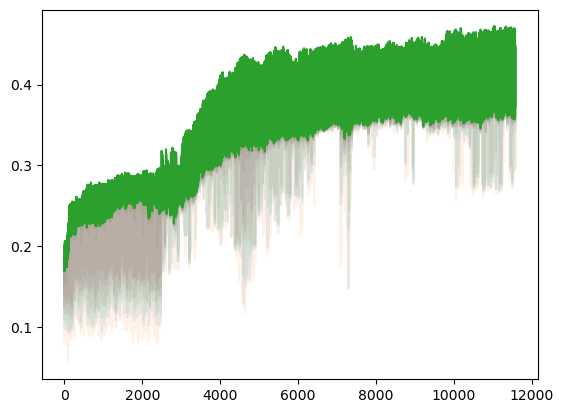

average best of last 100 generations 0.41172999999999993
generation 11581  test set: 6 evaluating performances|||||||||||| done!  best: 0.448 second: 0.448 third: 0.447
mutating in range: 0.043019922736575573
generation 11582  test set: 3 evaluating performances|||||||||||| done!  best: 0.377 second: 0.375 third: 0.375
mutating in range: 0.04790535094078698
generation 11583  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.439 third: 0.438
mutating in range: 0.039922039882179516
generation 11584  test set: 8 evaluating performances|||||||||||| done!  best: 0.465 second: 0.465 third: 0.465
mutating in range: 9.593683158415357e-06
generation 11585  test set: 3 evaluating performances|||||||||||| done!  best: 0.376 second: 0.376 third: 0.376
mutating in range: 0.043025181171460876
generation 11586  test set: 5 evaluating performances|||||||||||| done!  best: 0.448 second: 0.446 third: 0.446
mutating in range: 0.0007116925987991241
generation 11587  test set: 0 

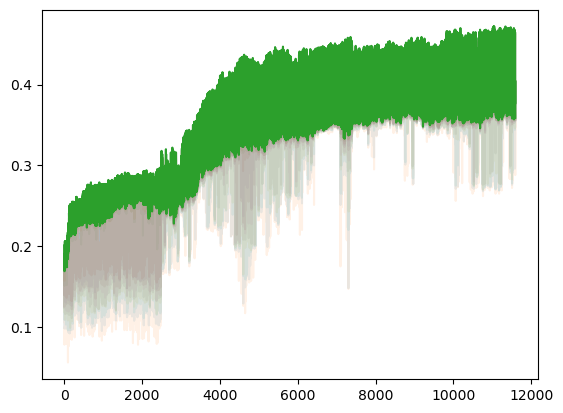

average best of last 100 generations 0.41214000000000006
generation 11591  test set: 3 evaluating performances|||||||||||| done!  best: 0.377 second: 0.375 third: 0.374
mutating in range: 0.0015974800898463537
generation 11592  test set: 2 evaluating performances|||||||||||| done!  best: 0.373 second: 0.373 third: 0.373
mutating in range: 0.0332875808747507
generation 11593  test set: 1 evaluating performances|||||||||||| done!  best: 0.357 second: 0.357 third: 0.357
mutating in range: 0.022079826626768717
generation 11594  test set: 5 evaluating performances|||||||||||| done!  best: 0.447 second: 0.447 third: 0.447
mutating in range: 0.0018533533905413235
generation 11595  test set: 3 evaluating performances|||||||||||| done!  best: 0.377 second: 0.377 third: 0.377
mutating in range: 0.02696165986674248
generation 11596  test set: 0 evaluating performances|||||||||||| done!  best: 0.406 second: 0.406 third: 0.406
mutating in range: 0.014330791033044627
generation 11597  test set: 5 ev

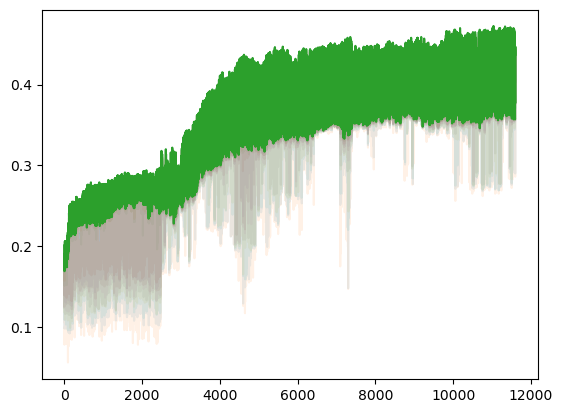

average best of last 100 generations 0.4111000000000001
generation 11601  test set: 2 evaluating performances|||||||||||| done!  best: 0.377 second: 0.375 third: 0.374
mutating in range: 0.012664000760002509
generation 11602  test set: 2 evaluating performances|||||||||||| done!  best: 0.378 second: 0.377 third: 0.375
mutating in range: 0.04026451515776625
generation 11603  test set: 7 evaluating performances|||||||||||| done!  best: 0.439 second: 0.439 third: 0.437
mutating in range: 0.009586970186049721
generation 11604  test set: 1 evaluating performances|||||||||||| done!  best: 0.356 second: 0.355 third: 0.355
mutating in range: 0.03723657925864453
generation 11605  test set: 9 evaluating performances|||||||||||| done!  best: 0.439 second: 0.438 third: 0.438
mutating in range: 0.02270358853774279
generation 11606  test set: 7 evaluating performances|||||||||||| done!  best: 0.442 second: 0.439 third: 0.437
mutating in range: 0.003706690496109366
generation 11607  test set: 7 evalu

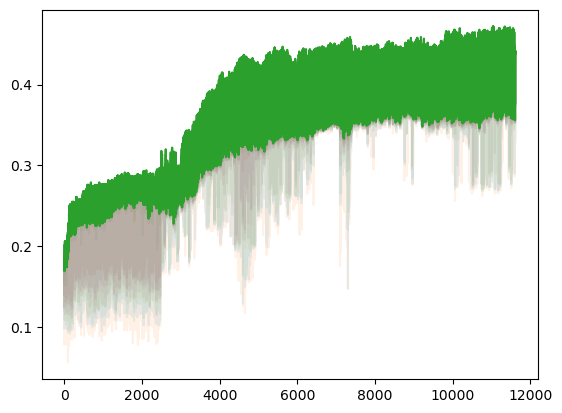

average best of last 100 generations 0.41240000000000004
generation 11611  test set: 9 evaluating performances|||||||||||| done!  best: 0.44 second: 0.439 third: 0.436
mutating in range: 0.008157965440948035
generation 11612  test set: 4 evaluating performances|||||||||||| done!  best: 0.377 second: 0.377 third: 0.376
mutating in range: 0.0292765519466229
generation 11613  test set: 1 evaluating performances|||||||||||| done!  best: 0.356 second: 0.356 third: 0.355
mutating in range: 0.014975431765887072
generation 11614  test set: 6 evaluating performances|||||||||||| done!  best: 0.446 second: 0.444 third: 0.443
mutating in range: 0.010953578625098437
generation 11615  test set: 5 evaluating performances|||||||||||| done!  best: 0.446 second: 0.446 third: 0.445
mutating in range: 0.03392075164277664
generation 11616  test set: 9 evaluating performances|||||||||||| done!  best: 0.438 second: 0.438 third: 0.437
mutating in range: 0.024632396790715
generation 11617  test set: 8 evaluati

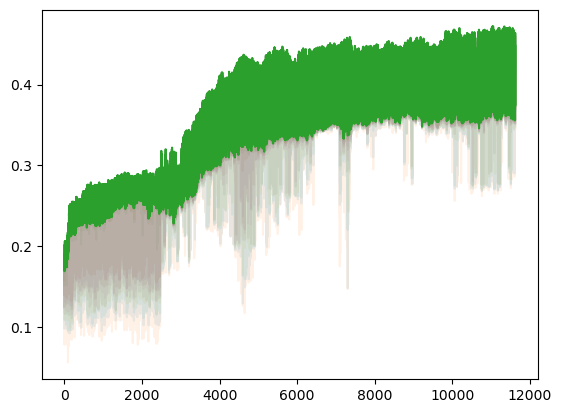

average best of last 100 generations 0.41292
generation 11621  test set: 8 evaluating performances|||||||||||| done!  best: 0.462 second: 0.462 third: 0.461
mutating in range: 0.01096858932969781
generation 11622  test set: 7 evaluating performances|||||||||||| done!  best: 0.439 second: 0.436 third: 0.436
mutating in range: 0.009104857604386724
generation 11623  test set: 6 evaluating performances|||||||||||| done!  best: 0.447 second: 0.443 third: 0.442
mutating in range: 0.016076473696901412
generation 11624  test set: 2 evaluating performances|||||||||||| done!  best: 0.376 second: 0.375 third: 0.374
mutating in range: 0.010448553335079425
generation 11625  test set: 8 evaluating performances|||||||||||| done!  best: 0.463 second: 0.463 third: 0.461
mutating in range: 0.013283639331751662
generation 11626  test set: 4 evaluating performances|||||||||||| done!  best: 0.376 second: 0.376 third: 0.375
mutating in range: 0.03995160814805049
generation 11627  test set: 4 evaluating perf

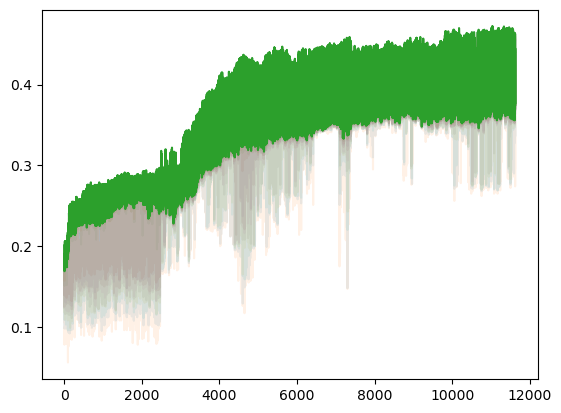

average best of last 100 generations 0.4146599999999999
generation 11631  test set: 2 evaluating performances|||||||||||| done!  best: 0.374 second: 0.374 third: 0.373
mutating in range: 0.030257998613474675
generation 11632  test set: 8 evaluating performances|||||||||||| done!  best: 0.462 second: 0.461 third: 0.461
mutating in range: 0.030019053341169128
generation 11633  test set: 5 evaluating performances|||||||||||| done!  best: 0.444 second: 0.443 third: 0.443
mutating in range: 0.0010795334175191795
generation 11634  test set: 6 evaluating performances|||||||||||| done!  best: 0.444 second: 0.444 third: 0.444
mutating in range: 0.015168941597746117
generation 11635  test set: 1 evaluating performances|||||||||||| done!  best: 0.361 second: 0.359 third: 0.359
mutating in range: 0.006679055434949755
generation 11636  test set: 5 evaluating performances|||||||||||| done!  best: 0.447 second: 0.446 third: 0.445
mutating in range: 0.01194383310199792
generation 11637  test set: 1 ev

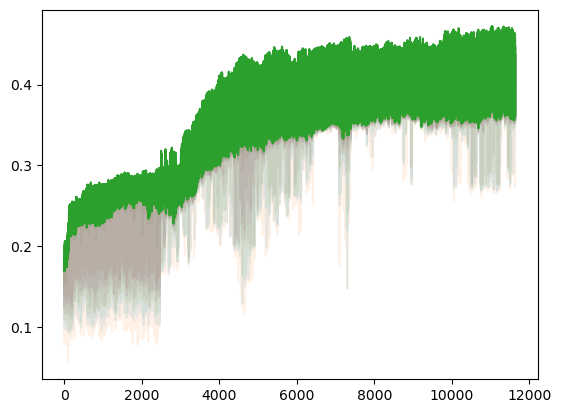

average best of last 100 generations 0.41548
generation 11641  test set: 1 evaluating performances|||||||||||| done!  best: 0.36 second: 0.359 third: 0.358
mutating in range: 0.03255532272936529
generation 11642  test set: 8 evaluating performances|||||||||||| done!  best: 0.463 second: 0.463 third: 0.461
mutating in range: 0.01541271284160748
generation 11643  test set: 8 evaluating performances|||||||||||| done!  best: 0.463 second: 0.463 third: 0.463
mutating in range: 0.025706793362026414
generation 11644  test set: 5 evaluating performances|||||||||||| done!  best: 0.445 second: 0.444 third: 0.443
mutating in range: 0.013871489170289653
generation 11645  test set: 3 evaluating performances|||||||||||| done!  best: 0.371 second: 0.369 third: 0.369
mutating in range: 0.04894936881253896
generation 11646  test set: 4 evaluating performances|||||||||||| done!  best: 0.381 second: 0.379 third: 0.375
mutating in range: 0.039044544085361524
generation 11647  test set: 7 evaluating perfor

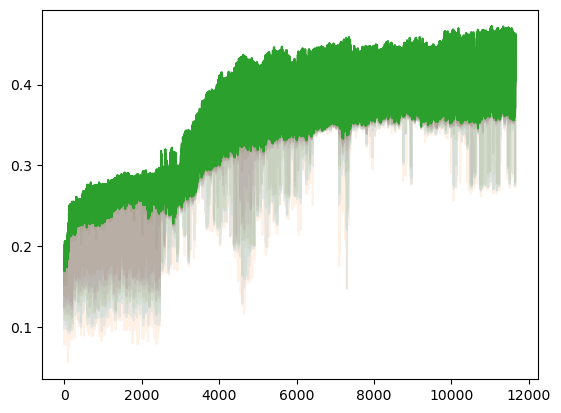

average best of last 100 generations 0.4162800000000001
generation 11651  test set: 2 evaluating performances|||||||||||| done!  best: 0.374 second: 0.372 third: 0.371
mutating in range: 0.015906307622178685
generation 11652  test set: 6 evaluating performances|||||||||||| done!  best: 0.446 second: 0.444 third: 0.444
mutating in range: 0.049087552441874585
generation 11653  test set: 0 evaluating performances|||||||||||| done!  best: 0.405 second: 0.402 third: 0.401
mutating in range: 0.046412640940620725
generation 11654  test set: 6 evaluating performances|||||||||||| done!  best: 0.446 second: 0.445 third: 0.444
mutating in range: 0.024932262469214952
generation 11655  test set: 2 evaluating performances|||||||||||| done!  best: 0.374 second: 0.374 third: 0.373
mutating in range: 0.008423509960502413
generation 11656  test set: 2 evaluating performances|||||||||||| done!  best: 0.376 second: 0.375 third: 0.374
mutating in range: 0.039005283093150316
generation 11657  test set: 8 ev

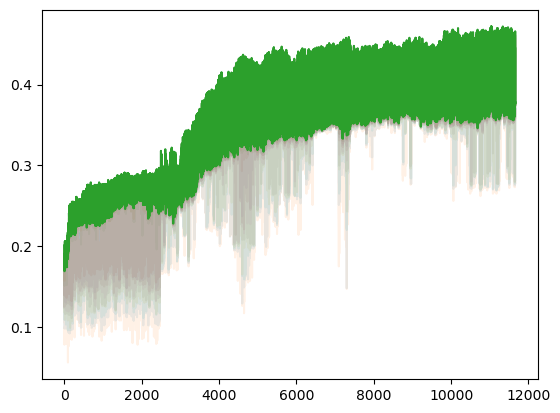

average best of last 100 generations 0.41503
generation 11661  test set: 0 evaluating performances|||||||||||| done!  best: 0.404 second: 0.403 third: 0.403
mutating in range: 0.045213303076763675
generation 11662  test set: 5 evaluating performances|||||||||||| done!  best: 0.445 second: 0.444 third: 0.443
mutating in range: 0.011215271174706049
generation 11663  test set: 0 evaluating performances|||||||||||| done!  best: 0.408 second: 0.407 third: 0.406
mutating in range: 0.02693465728675253
generation 11664  test set: 7 evaluating performances|||||||||||| done!  best: 0.438 second: 0.438 third: 0.437
mutating in range: 0.039726678072922864
generation 11665  test set: 9 evaluating performances|||||||||||| done!  best: 0.431 second: 0.428 third: 0.428
mutating in range: 0.03528844244742498
generation 11666  test set: 5 evaluating performances|||||||||||| done!  best: 0.447 second: 0.444 third: 0.442
mutating in range: 0.006592209640506503
generation 11667  test set: 1 evaluating perf

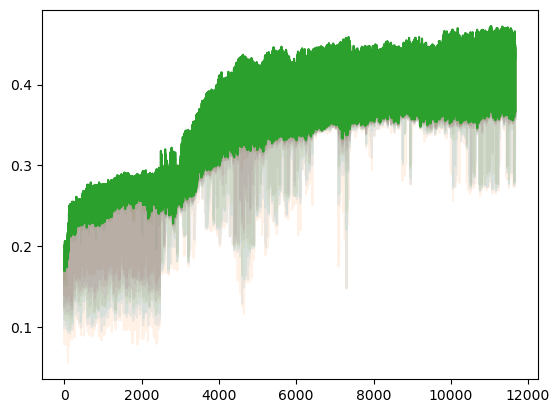

average best of last 100 generations 0.41446000000000005
generation 11671  test set: 3 evaluating performances|||||||||||| done!  best: 0.382 second: 0.381 third: 0.38
mutating in range: 0.046432033552434276
generation 11672  test set: 8 evaluating performances|||||||||||| done!  best: 0.467 second: 0.463 third: 0.459
mutating in range: 0.03991134681172574
generation 11673  test set: 2 evaluating performances|||||||||||| done!  best: 0.373 second: 0.373 third: 0.372
mutating in range: 0.020458462974913483
generation 11674  test set: 1 evaluating performances|||||||||||| done!  best: 0.365 second: 0.365 third: 0.363
mutating in range: 0.04126944800341388
generation 11675  test set: 5 evaluating performances|||||||||||| done!  best: 0.448 second: 0.447 third: 0.447
mutating in range: 0.037183311580188345
generation 11676  test set: 3 evaluating performances|||||||||||| done!  best: 0.38 second: 0.377 third: 0.376
mutating in range: 0.018609543568695253
generation 11677  test set: 4 evalu

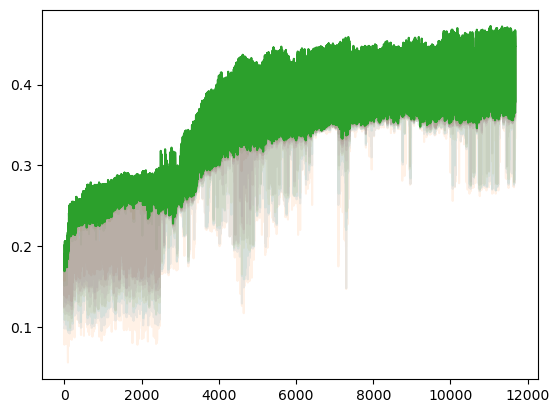

average best of last 100 generations 0.41340000000000005
generation 11681  test set: 6 evaluating performances|||||||||||| done!  best: 0.448 second: 0.448 third: 0.446
mutating in range: 0.04779711487630627
generation 11682  test set: 6 evaluating performances|||||||||||| done!  best: 0.448 second: 0.448 third: 0.446
mutating in range: 0.016150741530503183
generation 11683  test set: 2 evaluating performances|||||||||||| done!  best: 0.373 second: 0.372 third: 0.371
mutating in range: 0.017634440323202005
generation 11684  test set: 2 evaluating performances|||||||||||| done!  best: 0.375 second: 0.373 third: 0.373
mutating in range: 0.04174400542134697
generation 11685  test set: 3 evaluating performances|||||||||||| done!  best: 0.374 second: 0.373 third: 0.372
mutating in range: 0.021587951694206377
generation 11686  test set: 9 evaluating performances|||||||||||| done!  best: 0.431 second: 0.43 third: 0.428
mutating in range: 0.0069832666331887065
generation 11687  test set: 2 eva

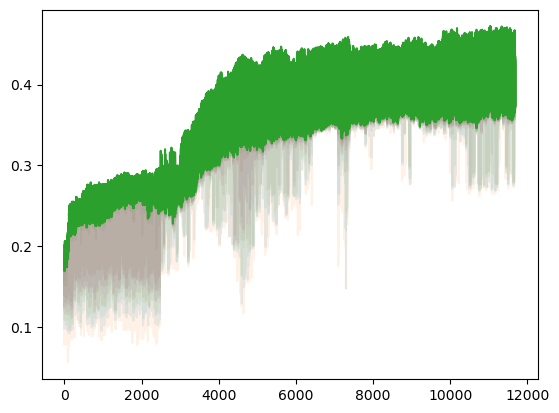

average best of last 100 generations 0.41301999999999994
generation 11691  test set: 5 evaluating performances|||||||||||| done!  best: 0.446 second: 0.446 third: 0.446
mutating in range: 0.017410941910481047
generation 11692  test set: 6 evaluating performances|||||||||||| done!  best: 0.445 second: 0.443 third: 0.442
mutating in range: 0.014105459278684224
generation 11693  test set: 7 evaluating performances|||||||||||| done!  best: 0.434 second: 0.434 third: 0.434
mutating in range: 0.039212438583900416
generation 11694  test set: 6 evaluating performances|||||||||||| done!  best: 0.446 second: 0.445 third: 0.444
mutating in range: 0.02944336781062756
generation 11695  test set: 3 evaluating performances|||||||||||| done!  best: 0.375 second: 0.373 third: 0.373
mutating in range: 0.048206379214385794
generation 11696  test set: 8 evaluating performances|||||||||||| done!  best: 0.468 second: 0.466 third: 0.464
mutating in range: 0.025149792219985746
generation 11697  test set: 1 ev

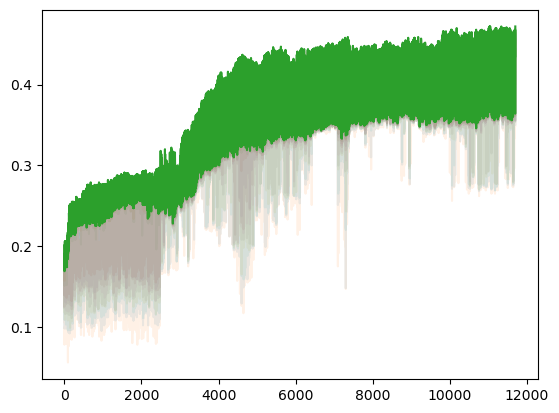

average best of last 100 generations 0.41525
generation 11701  test set: 8 evaluating performances|||||||||||| done!  best: 0.472 second: 0.472 third: 0.471
mutating in range: 0.0003637141884060835
generation 11702  test set: 2 evaluating performances|||||||||||| done!  best: 0.368 second: 0.368 third: 0.368
mutating in range: 0.030987888578253183
generation 11703  test set: 7 evaluating performances|||||||||||| done!  best: 0.437 second: 0.435 third: 0.434
mutating in range: 0.041746636684793316
generation 11704  test set: 0 evaluating performances|||||||||||| done!  best: 0.406 second: 0.405 third: 0.404
mutating in range: 0.008672899428865533
generation 11705  test set: 7 evaluating performances|||||||||||| done!  best: 0.436 second: 0.435 third: 0.435
mutating in range: 0.025529241343619224
generation 11706  test set: 7 evaluating performances|||||||||||| done!  best: 0.437 second: 0.436 third: 0.435
mutating in range: 0.0029639193485987148
generation 11707  test set: 5 evaluating 

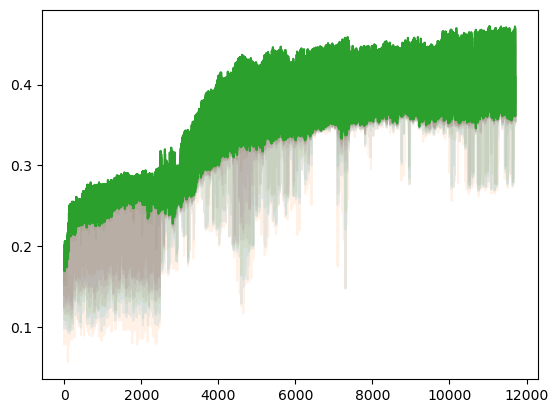

average best of last 100 generations 0.4163499999999999
generation 11711  test set: 2 evaluating performances|||||||||||| done!  best: 0.37 second: 0.37 third: 0.369
mutating in range: 0.0003612030357410756
generation 11712  test set: 6 evaluating performances|||||||||||| done!  best: 0.443 second: 0.443 third: 0.443
mutating in range: 0.011288311445181005
generation 11713  test set: 1 evaluating performances|||||||||||| done!  best: 0.362 second: 0.362 third: 0.361
mutating in range: 0.002621534263061226
generation 11714  test set: 2 evaluating performances|||||||||||| done!  best: 0.371 second: 0.371 third: 0.371
mutating in range: 0.02612504527760652
generation 11715  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.383 third: 0.382
mutating in range: 0.03219548699923489
generation 11716  test set: 3 evaluating performances|||||||||||| done!  best: 0.384 second: 0.383 third: 0.382
mutating in range: 0.04432897569702426
generation 11717  test set: 2 evalua

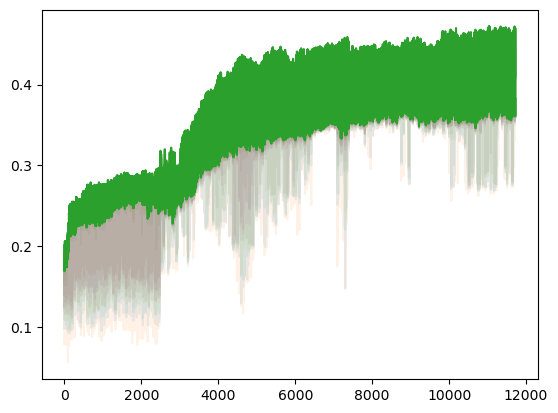

average best of last 100 generations 0.41367999999999994
generation 11721  test set: 0 evaluating performances|||||||||||| done!  best: 0.41 second: 0.41 third: 0.408
mutating in range: 0.02793970483798743


KeyboardInterrupt: 

In [107]:
generations = 5000
mutation_range = 0.05
population_size = 10
for gen in range(generations):
    #if(gen%10==0 and gen!=0): 
    #    mutation_range/=1.4
    #    print("decreasing mutation range from",mutation_range*1.4,"to",mutation_range)
    print("generation "+str(len(performance_over_time)+1), end=" ")
    test_set = np.random.randint(10)
    test_sets_used.append(test_set)
    print(" test set:",test_set,end=" ")
    evaluated_networks = evaluate_performance(next_generation, x_test[test_set], y_test_ohe[test_set])
    print(" best:", evaluated_networks[0][0], "second:", evaluated_networks[1][0], "third:", evaluated_networks[2][0])
    performance_over_time.append(list(np.array(evaluated_networks)[:,0]))
    generational_mutation_range = np.random.rand()*mutation_range
    mutation_ranges.append(generational_mutation_range)
    print("mutating in range:", generational_mutation_range)
    next_generation = repopulate(evaluated_networks, generational_mutation_range, n)
    if(gen%10==0):
        plt.plot(performance_over_time, alpha= 0.1)
        plt.plot(np.array(performance_over_time)[:,0])
        plt.show()
        print("average best of last 100 generations",np.average(np.array(performance_over_time)[-100:,0]))
    

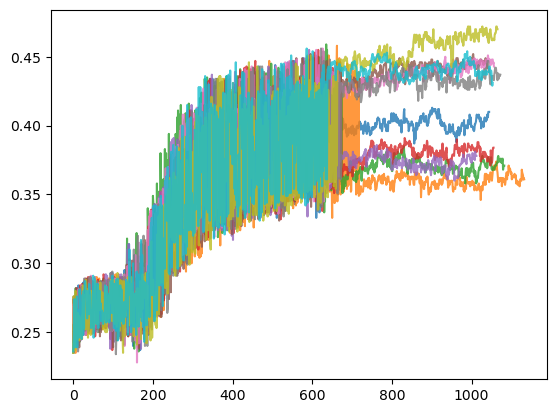

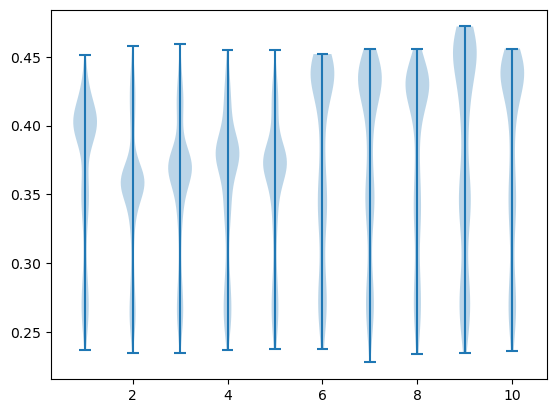

(10615,)
(10615,)


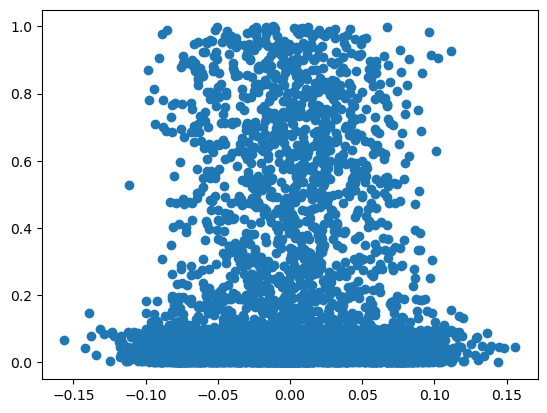

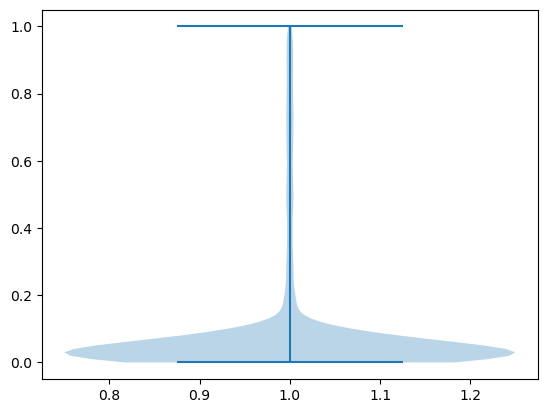

In [139]:
#visualising performance across the 10 different sets

performance_hist = np.array(performance_over_time)[-len(test_sets_used):,0]
set_perf = []
for i in range(10):
    set_perf.append([])

for i in range(len(test_sets_used)):
    set_perf[test_sets_used[i]].append(performance_hist[i])

for i in set_perf:
    plt.plot(i, alpha=0.8)
plt.show()

plt.violinplot(set_perf)
plt.show()

performance_hist = np.array(performance_over_time)[-len(test_sets_used):]
performance_changes = []
for i in range(len(performance_hist)-1):
    performance_changes.append(np.average(performance_hist[i])-np.average(performance_hist[i+1]))

print(np.array(mutation_ranges)[:len(mutation_ranges)].shape)
print(np.array(performance_changes)[:len(mutation_ranges)].shape)

plt.scatter(np.array(performance_changes)[:len(mutation_ranges)], np.array(mutation_ranges)[:len(performance_changes)])
plt.show()
plt.violinplot(np.array(mutation_ranges))
plt.show()

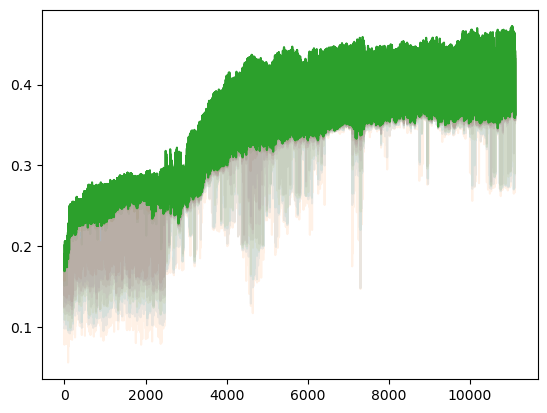

In [94]:
#TQDM -> loading bars

plt.plot(performance_over_time, alpha= 0.1)
plt.plot(np.array(performance_over_time)[:,0])
#plt.plot(list(0.99*np.ones(len(performance_over_time))))
plt.show()

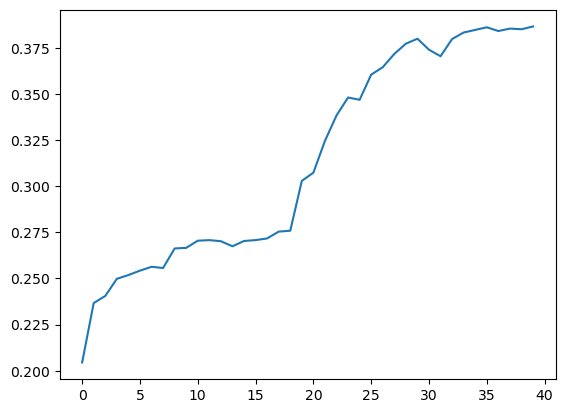

In [99]:
plt.plot(np.average(np.split(np.array(performance_over_time)[:6400,0], 40),axis =1))

In [125]:
log = {"training_run":training_run,
       "neuron_count":neuron_count,
       "connection_probability_dropoff":connection_probability_dropoff,
       "connection_probability_scalar":connection_probability_scalar,
       "input_layer_connectivity_multiplyer":input_layer_connectivity_multiplyer,
       "output_layer_connectivity_multiplyer":output_layer_connectivity_multiplyer,
       "weight_initialisation_range":weight_initialisation_range,
       "distances_from_input_output_layer_to_main_neuron_field":distances_from_input_output_layer_to_main_neuron_field,
       "n_closes_neurons_connection_probability":n_closes_neurons_connection_probability,
       "distance_metric":distance_metric,
       "activation_function":activation_function,
       "generation_size":generation_size,
       "n_survivors":n_survivors,
       "mutation_range":mutation_range,
       "training_set_size":training_set_size,
       "mutation_range_reducing_interval":mutation_range_reducing_interval,
       "mutation_range_reducing_factor":mutation_range_reducing_factor,
       "reducing_mutaiton_range":reducing_mutaiton_range,
       "stochastic_mutation_range":stochastic_mutation_range,
       "multiple_training_sets":multiple_training_sets,
       "keep_best_of_n_generations_keep_n_best":keep_best_of_n_generations_keep_n_best,
       "allow_topological_modification":allow_topological_modification,
       "non-uniform_distribution_in_stochastic_mutation_range":non_uniform_distribution_in_stochastic_mutation_range }


In [124]:
np.savetxt('training_run_'+str(training_run)+'_performance.csv', performance_over_time, delimiter=',')
np.savetxt('training_run_'+str(training_run)+'_test_sets_used.csv', test_sets_used, delimiter=',')
np.savetxt('training_run_'+str(training_run)+'_mutation_ranges.csv', mutation_ranges, delimiter=',')
np.save('training_run_'+str(training_run)+'_config.npy', np.array(log))

In [ ]:
#Ideas to improve GA
#take best of last 3 gens instead of best 3 of last gen
#Cap unused neurons (if collumn or line of adj matrix empty, kill both)
#topology modification